## Generating and testing multiple synthetic datasets along with various GARCH models

In [1]:
# All imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch
from arch.univariate import ARX, FIGARCH
from scipy.stats import norm

In [2]:
synthetic_datasets = []

Generating returns... 50/10000
0.870257020404976
Generating returns... 100/10000
0.11201962715931568
Generating returns... 150/10000
-5.0439027449976805
Generating returns... 200/10000
-0.38511807453584784
Generating returns... 250/10000
-2.2751338243746186
Generating returns... 300/10000
1.3321995957881403
Generating returns... 350/10000
-4.188841042370685
Generating returns... 400/10000
5.583999609896251
Generating returns... 450/10000
-4.191482932202906
Generating returns... 500/10000
-2.0610039660988164
Generating returns... 550/10000
-1.2169637150100008
Generating returns... 600/10000
-1.892478820695457
Generating returns... 650/10000
-5.109616549764065
Generating returns... 700/10000
-1.8603137870181334
Generating returns... 750/10000
-2.0639596120933765
Generating returns... 800/10000
1.6889575914366342
Generating returns... 850/10000
4.488132546913501
Generating returns... 900/10000
1.688982280634626
Generating returns... 950/10000
-7.005833769037076
Generating returns... 1000/

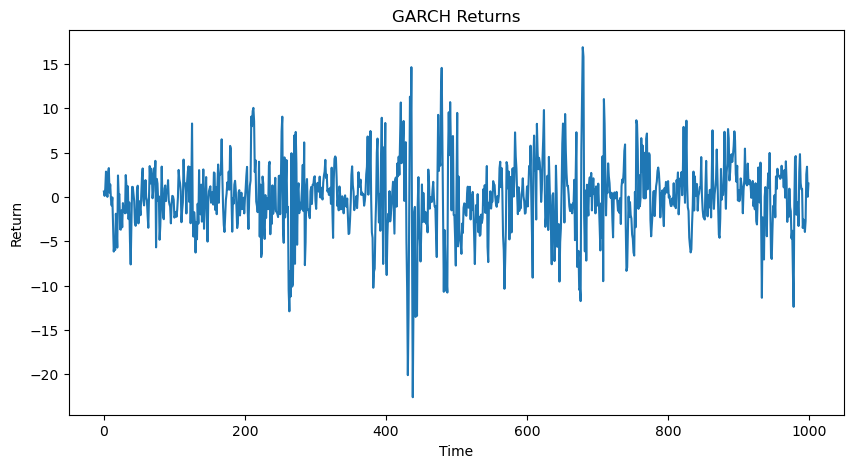

In [ ]:
# Generating GARCH - returns
np.random.seed(42)
n = 10000
omega, alpha1, alpha2, beta1, beta2 = 1, 0.5, 0.1, 0.5, 0.4
phi = 0.5  # AR(1) coefficient

returns_np = np.zeros(n)
returns = []
eps = np.zeros(n)
sigma2 = np.ones(n)

for t in range(2, n):
    if t%50 == 0:
        print(f"Generating returns... {t}/{n}")
        print(returns_np[t-1])
    sigma2[t] = omega + alpha1 * eps[t-1]**2 + beta1 * sigma2[t-1]
    eps[t] = np.random.normal(0, np.sqrt(sigma2[t]))
    returns_np[t] = phi * returns_np[t-1] + eps[t]
    returns.append(returns_np[t])
plt.figure(figsize=(10, 5))
plt.plot(returns[:1000])
plt.title('GARCH Returns')
plt.xlabel('Time')
plt.ylabel('Return')
plt.show()
synthetic_datasets.append(returns)

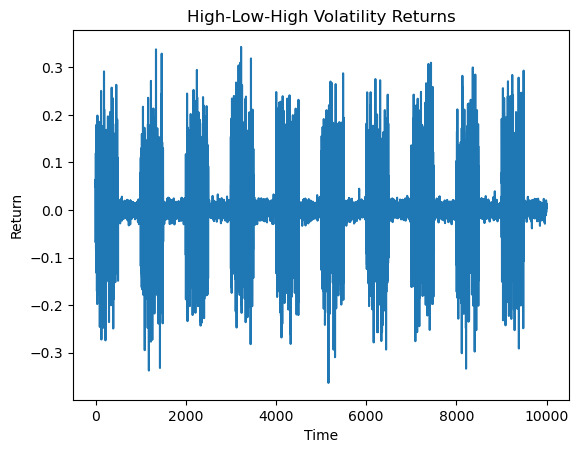

In [ ]:
n = 10000
period = 500
low_vol = 0.01
high_vol = 0.1

vols = np.ones(n) * low_vol
for i in range(0, n, period*2):
    vols[i:i+period] = high_vol

returns_vol = np.random.normal(0, vols)

plt.figure()
plt.plot(returns_vol)
plt.title('High-Low-High Volatility Returns')
plt.xlabel('Time')
plt.ylabel('Return')
plt.show()

# Append to synthetic_datasets
synthetic_datasets.append(returns_vol)

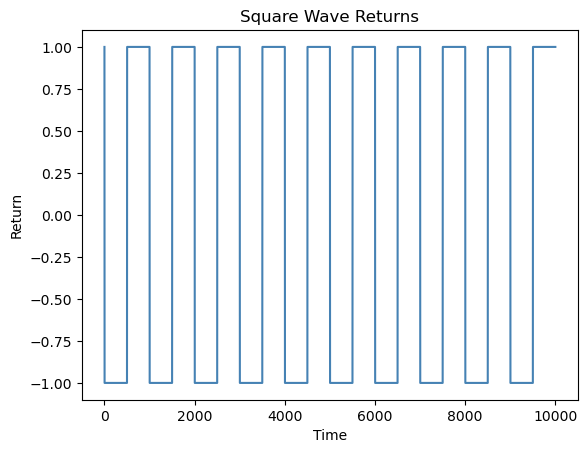

In [5]:
# Square wave plot
n = 10000
returns = []
v = 1
for i in range (0, n):
    returns.append(v)
    if(i % 500 == 0):
        v = v * -1     
plt.plot(returns, color='steelblue')
plt.title('Square Wave Returns')
plt.xlabel('Time')
plt.ylabel('Return')

synthetic_datasets.append(returns)

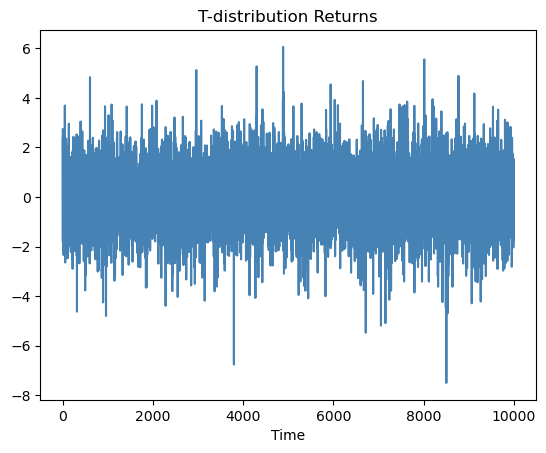

In [6]:
# Heavy-tailed distribution (t-distribution)
n = 10000
returns = []
v = 0
for i in range (0, n):
    v = np.random.standard_t(10, 1)
    returns.append(v[0])
plt.plot(returns, color='steelblue')
plt.title('T-distribution Returns')
plt.xlabel('Time')
synthetic_datasets.append(returns)

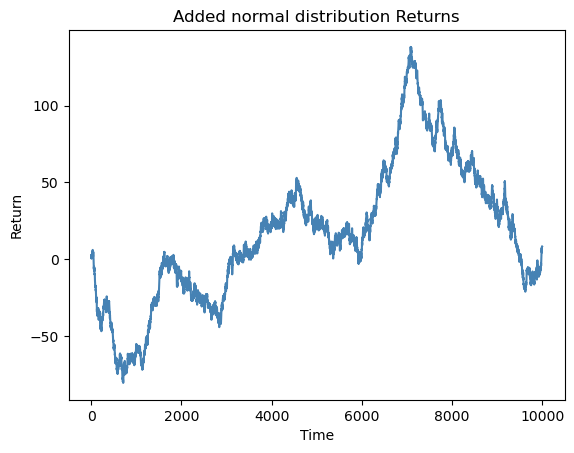

In [ ]:
# Adding gaussian noise every timestep
n = 10000
returns = []
v = 0
for i in range (0, n):
    v = v + np.random.normal(0, 1)
    returns.append(v)
plt.plot(returns, color='steelblue')
plt.title('Added normal distribution Returns')
plt.xlabel('Time')
plt.ylabel('Return')
synthetic_datasets.append(returns)

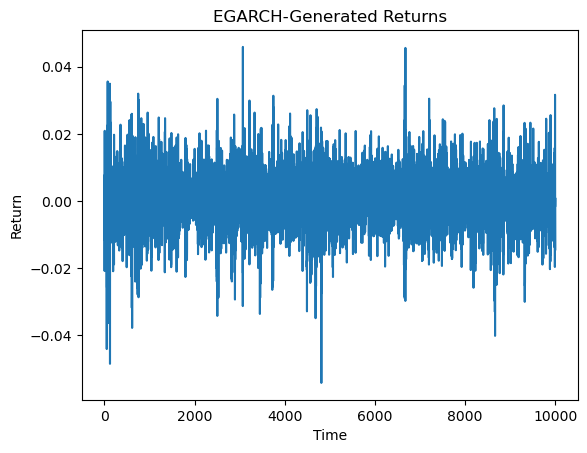

In [ ]:
# Generating E-GARCH - returns
n = 10000
omega = -0.5
alpha = 0.1
beta = 0.95
gamma = -0.2  

log_sigma2 = np.zeros(n)
sigma = np.zeros(n)
returns_egarch = np.zeros(n)
z = np.random.normal(size=n)

log_sigma2[0] = omega / (1 - beta)
sigma[0] = np.exp(0.5 * log_sigma2[0])

for t in range(1, n):
    log_sigma2[t] = (omega 
                     + beta * log_sigma2[t-1] 
                     + alpha * (abs(z[t-1]) - np.sqrt(2/np.pi))
                     + gamma * z[t-1])
    sigma[t] = np.exp(0.5 * log_sigma2[t])
    returns_egarch[t] = sigma[t] * z[t]

plt.figure()
plt.plot(returns_egarch)
plt.title('EGARCH-Generated Returns')
plt.xlabel('Time')
plt.ylabel('Return')
plt.show()

synthetic_datasets.append(returns_egarch)


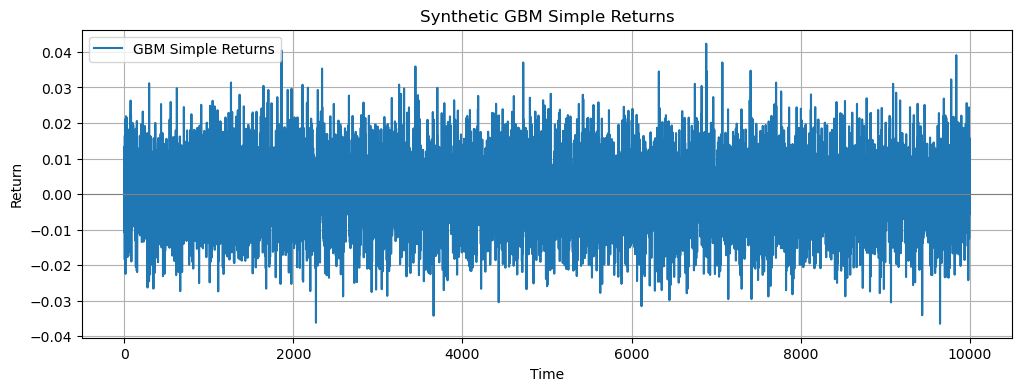

In [ ]:
# Generating geometric brownian motion
n = 10000              
mu = 0.0005           
sigma = 0.01          
S0 = 100
prices_bm = [S0]
returns_bm = []       

for _ in range(1, n):
    shock = np.random.normal(loc=(mu - 0.5 * sigma ** 2), scale=sigma)
    S_new = prices_bm[-1] * np.exp(shock)
    prices_bm.append(S_new)
    r = (S_new / prices_bm[-2]) - 1
    returns_bm.append(r)

plt.figure(figsize=(12, 4))
plt.plot(returns_bm, label='GBM Simple Returns')
plt.axhline(0, color='gray', linewidth=0.8)
plt.title('Synthetic GBM Simple Returns')
plt.xlabel('Time')
plt.ylabel('Return')
plt.grid(True)
plt.legend()
plt.show()

synthetic_datasets.append(returns_bm)

In [10]:
print(len(synthetic_datasets))
# 0 -> GARCH generated data
# 1 -> high low high
# 2 ->square wave
# 3 -> t distribution
# 4 -> added normal
# 5 -> EGarch generated data
# 6 -> GBM


7


In [ ]:
# Gets log returns and checks ARCH effect
def get_log_returns(returns_list):
    returns = pd.Series(returns_list, dtype=float)
    returns = returns.clip(lower=-0.9999)  
    returns= np.log1p(returns).dropna()  
    returns.name = 'Log_Returns'

    g0 = arch_model(returns, mean='Constant', vol='GARCH', p=1, q=1)
    r0 = g0.fit(disp='off')

    lm_stat, lm_pvalue, _, _ = het_arch(r0.resid)
    print(f"ARCH LM test p‑value = {lm_pvalue:.4f}")
    if(lm_pvalue < 0.1):
        print("ARCH effect detected")
    else:
        print("No ARCH effect detected")
    return returns

In [ ]:

def work(returns):
    
    rolling_vol = returns.rolling(window=21).std()
    plt.figure(figsize=(15, 4))
    plt.plot(rolling_vol, color='red')
    plt.title('Rolling Volatility (21-Day Standard Deviation)')
    plt.xlabel('Time')
    plt.ylabel('Rolling Std Dev')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Fitting AR(1) model to get residuals to fit GARCH model

    ar_model = AutoReg(returns, lags=1).fit()
    print(ar_model.summary())

    residuals = ar_model.resid

    print("\nGARCH Model Order Selection:")
    best_aic = np.inf
    best_order = None
    best_model = None

    # Trying different p, q values for GARCH model and finding best one using AIC

    for p in range(1, 5):
        for q in range(1, 5):
            model_candidate = arch_model(residuals, p=p, q=q, rescale=False)
            res_candidate = model_candidate.fit(disp="off")
            print(f'GARCH({p},{q}) - AIC: {res_candidate.aic:.2f}, BIC: {res_candidate.bic:.2f}')
            if res_candidate.aic < best_aic:
                best_aic = res_candidate.aic
                best_order = (p, q)
                best_model = res_candidate

    print(f"\n Best GARCH Order (by AIC): GARCH{best_order}")
    # print(best_model.summary())

    if returns.name is None:
        returns.name = "Log_Returns"

    # print("AR model parameters:", ar_model.params.index.tolist())
    # Choose a random time step t such that t+1 exists
    t = np.random.randint(1000, len(returns) - 2)

    print(f"Forecasting for time step t = {t}")

    confidence_level = 0.95 
    z = norm.ppf(1 - (1 - confidence_level) / 2)

    forecast = best_model.forecast(start=returns.index[t], horizon=1)
    predicted_vol = np.sqrt(forecast.variance.values[-1, 0])

    if "L1.Log_Returns" in ar_model.params.index:
        lag_param = "L1.Log_Returns"
    else:
        lag_param = ar_model.params.index[1]
        print(f"Using fallback lag parameter name: {lag_param}")


    k = 100
    confidence_level = 0.95
    z = norm.ppf(1 - (1 - confidence_level) / 2)

    ar_params = ar_model.params
    if "L1.Log_Returns" in ar_params.index:
        lag_param = "L1.Log_Returns"
    else:
        lag_param = ar_params.index[1]
        print("Using fallback AR lag parameter:", lag_param)

    # Using the best GARCH model 
    garch_params = best_model.params
    omega_val = garch_params['omega']
    alpha1_val = garch_params.get('alpha[1]', 0)
    alpha2_val = garch_params.get('alpha[2]', 0)  
    beta1_val = garch_params.get('beta[1]', 0)
    beta2_val = garch_params.get('beta[2]', 0)

    history_returns = list(returns.iloc[-2:])
    history_resids = list(ar_model.resid.iloc[-2:])
    history_sigma2 = list(best_model.conditional_volatility.iloc[-2:]**2)

    predicted_means = []
    predicted_stds = []
    true_returns = []

    for i in range(k):
        pred_mean = ar_params['const'] + ar_params[lag_param] * history_returns[-1]
        predicted_means.append(pred_mean)

        sigma2_pred = (omega_val +
                    alpha1_val * history_resids[-1]**2 +
                    alpha2_val * (history_resids[-2]**2 if len(history_resids) >= 2 else 0) +
                    beta1_val * history_sigma2[-1] +
                    beta2_val * (history_sigma2[-2] if len(history_sigma2) >= 2 else 0))
        predicted_stds.append(np.sqrt(sigma2_pred))

        idx = len(returns) - k + i
        true_returns.append(returns.iloc[idx])

        resid = true_returns[-1] - pred_mean
        history_resids.append(resid)
        history_sigma2.append(sigma2_pred)
        history_returns.append(true_returns[-1])

    forecast_index = returns.index[-k:]

    # Plotting forecast with 100-step ahead rolling forecast

    fig, axes = plt.subplots(1, 2, figsize=(13, 6))
    axes[0].plot(forecast_index, predicted_means, color='red', label='Predicted Mean')
    axes[0].fill_between(forecast_index,
                    np.array(predicted_means) - z * np.array(predicted_stds),
                    np.array(predicted_means) + z * np.array(predicted_stds),
                    color='red', alpha=0.2, label=f'{confidence_level*100:.0f}% CI')
    axes[0].plot(forecast_index, true_returns, marker='o', linestyle='--', color='green', label='True Returns')
    axes[0].axvline(returns.index[-k], linestyle='--', color='gray', alpha=0.6)
    axes[0].set_title(f"{k}-Step Ahead Rolling Forecast (AR(1) + GARCH)")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Return")
    axes[0].legend()
    axes[0].grid(True)
    
    predicted_var_series = best_model.conditional_volatility ** 2
    window = 20  # 20-day rolling window for realized variance
    realized_var_series = returns.rolling(window=window).var()

    # Plotting Predicted vs. Realized Variance for GARCH
    axes[1].plot(predicted_var_series, label='Predicted Variance (GARCH)', color='red', alpha=0.7)
    axes[1].plot(realized_var_series, label=f'Realized Variance (Rolling {window})', color='blue', alpha=0.5)
    axes[1].set_title('Predicted vs. Realized Variance')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Variance')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

    n_returns = len(returns)
    print(f"Total number of return observations: {n_returns}")

    start_t = int(n_returns * 0.8)
    end_t = n_returns - 2  

    print(f"Testing range: start_t = {start_t}, end_t = {end_t}")

    confidence_level = 0.95
    z = norm.ppf(1 - (1 - confidence_level) / 2)
    print(f"z-value: {z}")

    ar_params = ar_model.params
    if "L1.Log_Returns" in ar_params.index:
        lag_param = "L1.Log_Returns"
    else:
        lag_param = ar_params.index[1]
        print(f"Using fallback AR lag parameter: {lag_param}")

    count_in_ci = 0
    total_checks = 0

    for t in range(start_t, end_t):
        if t % 500 == 0:
            print(f"Processing t = {t} / {end_t}")
        predicted_mean = ar_model.params['const'] + ar_model.params[lag_param] * returns.iloc[t - 1]

        forecast = best_model.forecast(start=returns.index[t], horizon=1)
        predicted_vol = np.sqrt(forecast.variance.values[-1, 0])

        ci_lower = predicted_mean - z * predicted_vol
        ci_upper = predicted_mean + z * predicted_vol

        true_ret = returns.iloc[t + 1]
        if ci_lower <= true_ret <= ci_upper:
            count_in_ci += 1
        total_checks += 1

    coverage = count_in_ci / total_checks
    print(f"User-defined Confidence Level: {confidence_level*100:.1f}%")
    print(f"Observed Coverage: {coverage*100:.2f}% ({count_in_ci} out of {total_checks} instances)")



    predicted_vol_series = best_model.conditional_volatility

    actual_vol_series = np.sqrt(returns.rolling(window=20).var())

    common_index = predicted_vol_series.index[1300:2400]

    rmse = np.sqrt(np.mean((predicted_vol_series.loc[common_index] - actual_vol_series.loc[common_index]) ** 2))
    print(f"RMSE between predicted and actual volatility: {rmse:.4f}")


    # ---- 1. Fit EGARCH (normal) on AR(1) residuals ----
    try:
        egarch_model = arch_model(residuals, vol='EGARCH', p=1, q=1, dist='normal', rescale=False)
        egarch_fit = egarch_model.fit(disp="off")
        print("\n--- EGARCH (normal) Model Summary ---")
        print(egarch_fit.summary())
    except Exception as e:
        print("\nEGARCH model could not be estimated:", e)

    # ---- 2. Fit FIGARCH (normal) on AR(1) residuals ----

    try:
        figarch_spec = ARX(residuals, lags=0, rescale=False)
        figarch_spec.volatility = FIGARCH(p=1, q=1)

        # Fit the model (it estimates the fractional d parameter)
        figarch_fit = figarch_spec.fit(disp="off")
        print("\n--- FIGARCH (as FIGARCH mimic) Model Summary ---")
        print(figarch_fit.summary())

    except Exception as e:
        print("\nFIGARCH model could not be estimated:", e)

    # ---- 3. Fit GJR-GARCH (normal) on AR(1) residuals ----
    try:
        gjr_model = arch_model(residuals, vol='GARCH', p=1, o=1, q=1, dist='normal', rescale=False)
        gjr_fit = gjr_model.fit(disp="off")
        print("\n--- GJR-GARCH (normal) Model Summary ---")
        print(gjr_fit.summary())
    except Exception as e:
        print("\nGJR-GARCH model could not be estimated:", e)

    # ---- 4. Fit GARCH-M (GARCH in Mean) on raw returns ----
    try:
        lagged_vol = best_model.conditional_volatility.shift(1).dropna()
        returns_for_garchm = returns.loc[lagged_vol.index]

        garchm_model = arch_model(returns_for_garchm, mean='ARX', lags=0, x=lagged_vol,
                                vol='GARCH', p=1, q=1, dist='normal', rescale=False)
        garchm_fit = garchm_model.fit(disp="off")
        print("\n--- GARCH-M (in-Mean) Model Summary ---")
        print(garchm_fit.summary())
    except Exception as e:
        print("\nGARCH-M model could not be estimated:", e)



    print("\nAdditional Model Comparison:")
    # Adding the fitted models to try on synthetic data
    variant_models = {
        "EGARCH": egarch_fit if 'egarch_fit' in globals() and egarch_fit is not None else None,
        "FIGARCH": figarch_fit if 'figarch_fit' in globals() and figarch_fit is not None else None,
        "GJR-GARCH": gjr_fit if 'gjr_fit' in globals() and gjr_fit is not None else None,
        "GARCH-M": garchm_fit if 'garchm_fit' in globals() and garchm_fit is not None else None
    }

    for label, fit in variant_models.items():
        if fit is not None:
            print(f"{label}: AIC = {fit.aic:.2f}, BIC = {fit.bic:.2f}")
        else:
            print(f"{label}: Model not available")

    variants = {
        "EGARCH": egarch_fit,
        "FIGARCH": figarch_fit,
        "GJR-GARCH": gjr_fit,
        "GARCH-M": garchm_fit
    }

    if returns.name is None:
        returns.name = "Log_Returns"

    print("AR model parameters:", ar_model.params.index.tolist())
    if "L1.Log_Returns" in ar_model.params.index:
        lag_param = "L1.Log_Returns"
    else:
        lag_param = ar_model.params.index[1]
        print(f"Using fallback lag parameter name: {lag_param}")

    t_forecast = np.random.randint(1000, len(returns) - 2)
    print(f"\nOne-step forecast will use t = {t_forecast} (forecast at t+1)")

    confidence_level = 0.95
    z = norm.ppf(1 - (1 - confidence_level) / 2)
    print(f"z-value: {z:.4f}")

    k = 100

    fig, axes = plt.subplots(4, 2, figsize=(16, 12))
    row = 0
    for variant_name, model_fit in variants.items():
        print(f"\n================= Variant: {variant_name} =================")

        var_params = model_fit.params
        omega_val = var_params['omega']
        alpha1_val = var_params.get('alpha[1]', 0)
        alpha2_val = var_params.get('alpha[2]', 0)
        beta1_val = var_params.get('beta[1]', 0)
        beta2_val = var_params.get('beta[2]', 0)

        try:
            history_returns = list(returns.iloc[-2:])
            history_resids = list(ar_model.resid.iloc[-2:])
            history_sigma2 = list(model_fit.conditional_volatility.iloc[-2:]**2)
        except Exception as e:
            print(f"Error initializing history for {variant_name}: {e}")
            continue

        pred_means = []
        pred_stds = []
        true_forecast_returns = []

        for i in range(k):
            pred_mean = ar_model.params['const'] + ar_model.params[lag_param] * history_returns[-1]
            pred_means.append(pred_mean)
            sigma2_pred = (omega_val +
                        alpha1_val * history_resids[-1]**2 +
                        alpha2_val * (history_resids[-2]**2 if len(history_resids) >= 2 else 0) +
                        beta1_val * history_sigma2[-1] +
                        beta2_val * (history_sigma2[-2] if len(history_sigma2) >= 2 else 0))
            # print(omega_val, alpha1_val, alpha2_val, beta1_val, beta2_val)
            pred_stds.append(np.sqrt(sigma2_pred))
            idx = len(returns) - k + i  
            true_forecast_returns.append(returns.iloc[idx])
            resid = true_forecast_returns[-1] - pred_mean
            history_resids.append(resid)
            history_sigma2.append(sigma2_pred)
            history_returns.append(true_forecast_returns[-1])

        forecast_index = returns.index[-k:]

        # Plotting forecast with 100-step ahead rolling forecast

        axes[row, 0].plot(forecast_index, pred_means, color='red', label='Predicted Mean')
        axes[row, 0].fill_between(forecast_index,
                        np.array(pred_means) - z * np.array(pred_stds),
                        np.array(pred_means) + z * np.array(pred_stds),
                        color='red', alpha=0.2, label=f'{confidence_level*100:.0f}% CI')
        axes[row, 0].plot(forecast_index, true_forecast_returns, marker='o', linestyle='--', color='green', label='True Returns')
        axes[row, 0].axvline(returns.index[-k], linestyle='--', color='gray', alpha=0.6)
        axes[row, 0].set_title(f"{variant_name} - {k}-Step Ahead Rolling Forecast (AR(1) + {variant_name})")
        axes[row, 0].set_xlabel("Time")
        axes[row, 0].set_ylabel("Return")
        axes[row, 0].legend()
        axes[row, 0].grid(True)

        # Finding confidence interval bounds
        lower_ci = np.array(pred_means) - z * np.array(pred_stds)
        upper_ci = np.array(pred_means) + z * np.array(pred_stds)

        print(f"{variant_name} - Confidence Interval Summary for the {k}-step forecast:")
        print(f"Lower Bound: min = {lower_ci.min():.4f}, max = {lower_ci.max():.4f}")
        print(f"Upper Bound: min = {upper_ci.min():.4f}, max = {upper_ci.max():.4f}\n")

        ### Plotting Predicted vs. Realized Variance
        try:
            pred_var_series = model_fit.conditional_volatility ** 2
            window = 20  
            realized_var_series = returns.rolling(window=window).var()
            axes[row, 1].plot(pred_var_series[1300:2400], label=f'Predicted Variance ({variant_name})', color='red', alpha=0.7)
            axes[row, 1].plot(realized_var_series[1300:2400], label=f'Realized Variance (Rolling {window})', color='blue', alpha=0.5)
            axes[row, 1].set_title(f"{variant_name} - Predicted vs. Realized Variance")
            axes[row, 1].set_xlabel("Time")
            axes[row, 1].set_ylabel("Variance")
            axes[row, 1].legend()
            axes[row, 1].grid(True)
        except Exception as e:
            print(f"{variant_name} - Failed to plot Predicted vs. Realized Variance: {e}")
        row += 1
    plt.tight_layout()
    plt.show()
        

ARCH LM test p‑value = 0.0000
ARCH effect detected


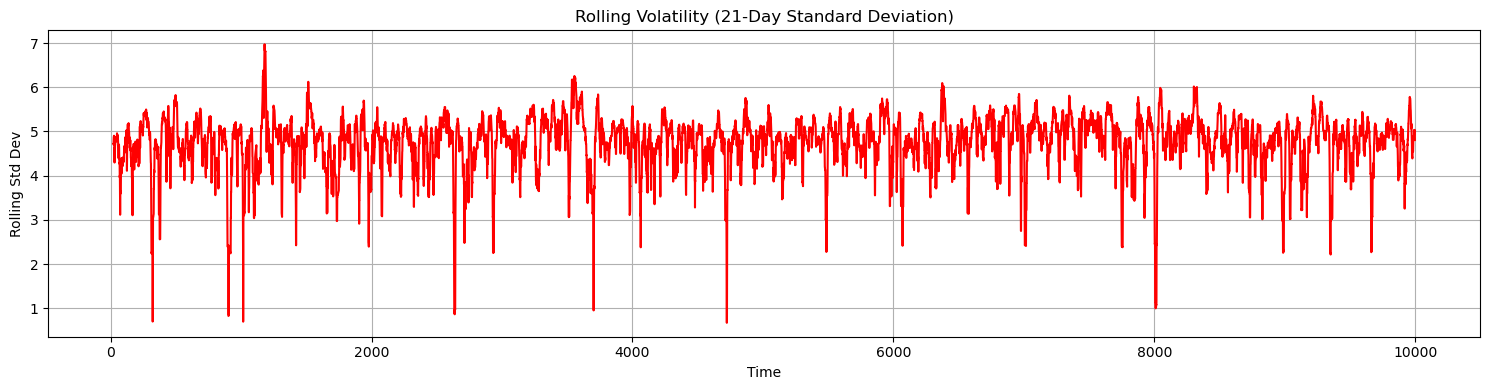

                            AutoReg Model Results                             
Dep. Variable:            Log_Returns   No. Observations:                 9998
Model:                     AutoReg(1)   Log Likelihood              -29588.223
Method:               Conditional MLE   S.D. of innovations              4.668
Date:                Sat, 12 Apr 2025   AIC                          59182.445
Time:                        19:57:23   BIC                          59204.075
Sample:                             1   HQIC                         59189.767
                                 9998                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.0232      0.055    -37.054      0.000      -2.130      -1.916
Log_Returns.L1     0.3241      0.009     34.253      0.000       0.306       0.343
                                    

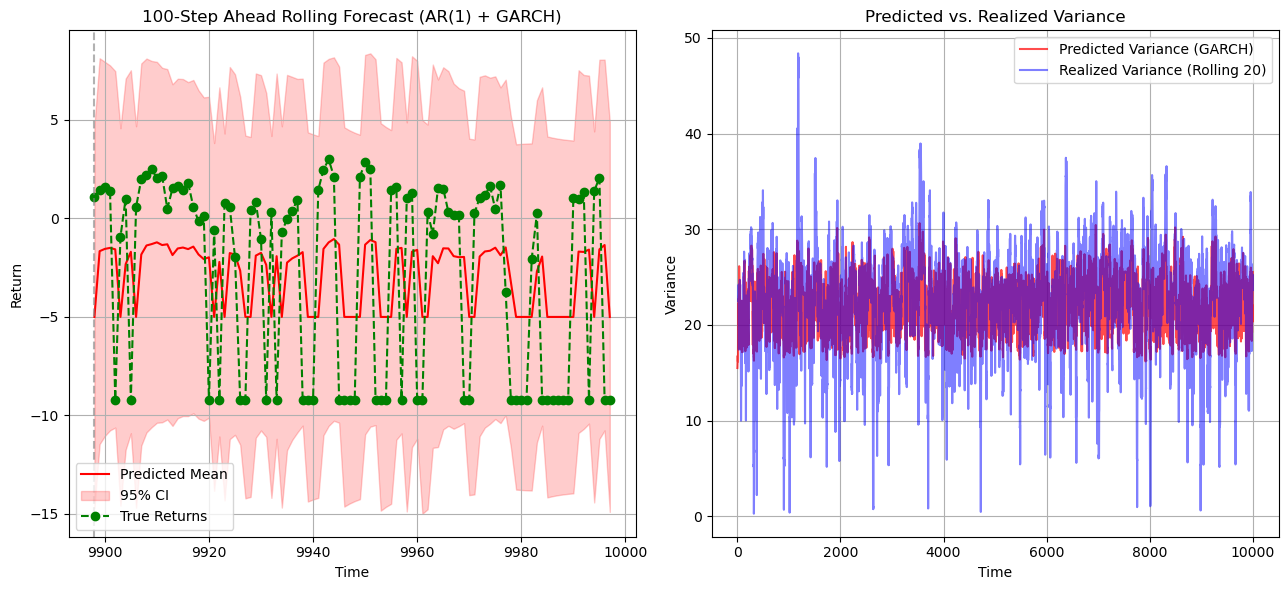

Total number of return observations: 9998
Testing range: start_t = 7998, end_t = 9996
z-value: 1.959963984540054
Using fallback AR lag parameter: Log_Returns.L1
Processing t = 8000 / 9996
Processing t = 8500 / 9996
Processing t = 9000 / 9996
Processing t = 9500 / 9996
User-defined Confidence Level: 95.0%
Observed Coverage: 100.00% (1998 out of 1998 instances)
RMSE between predicted and actual volatility: 0.5053

--- EGARCH (normal) Model Summary ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -29561.0
Distribution:                  Normal   AIC:                           59130.0
Method:            Maximum Likelihood   BIC:                           59158.8
                                        No. Observations:               

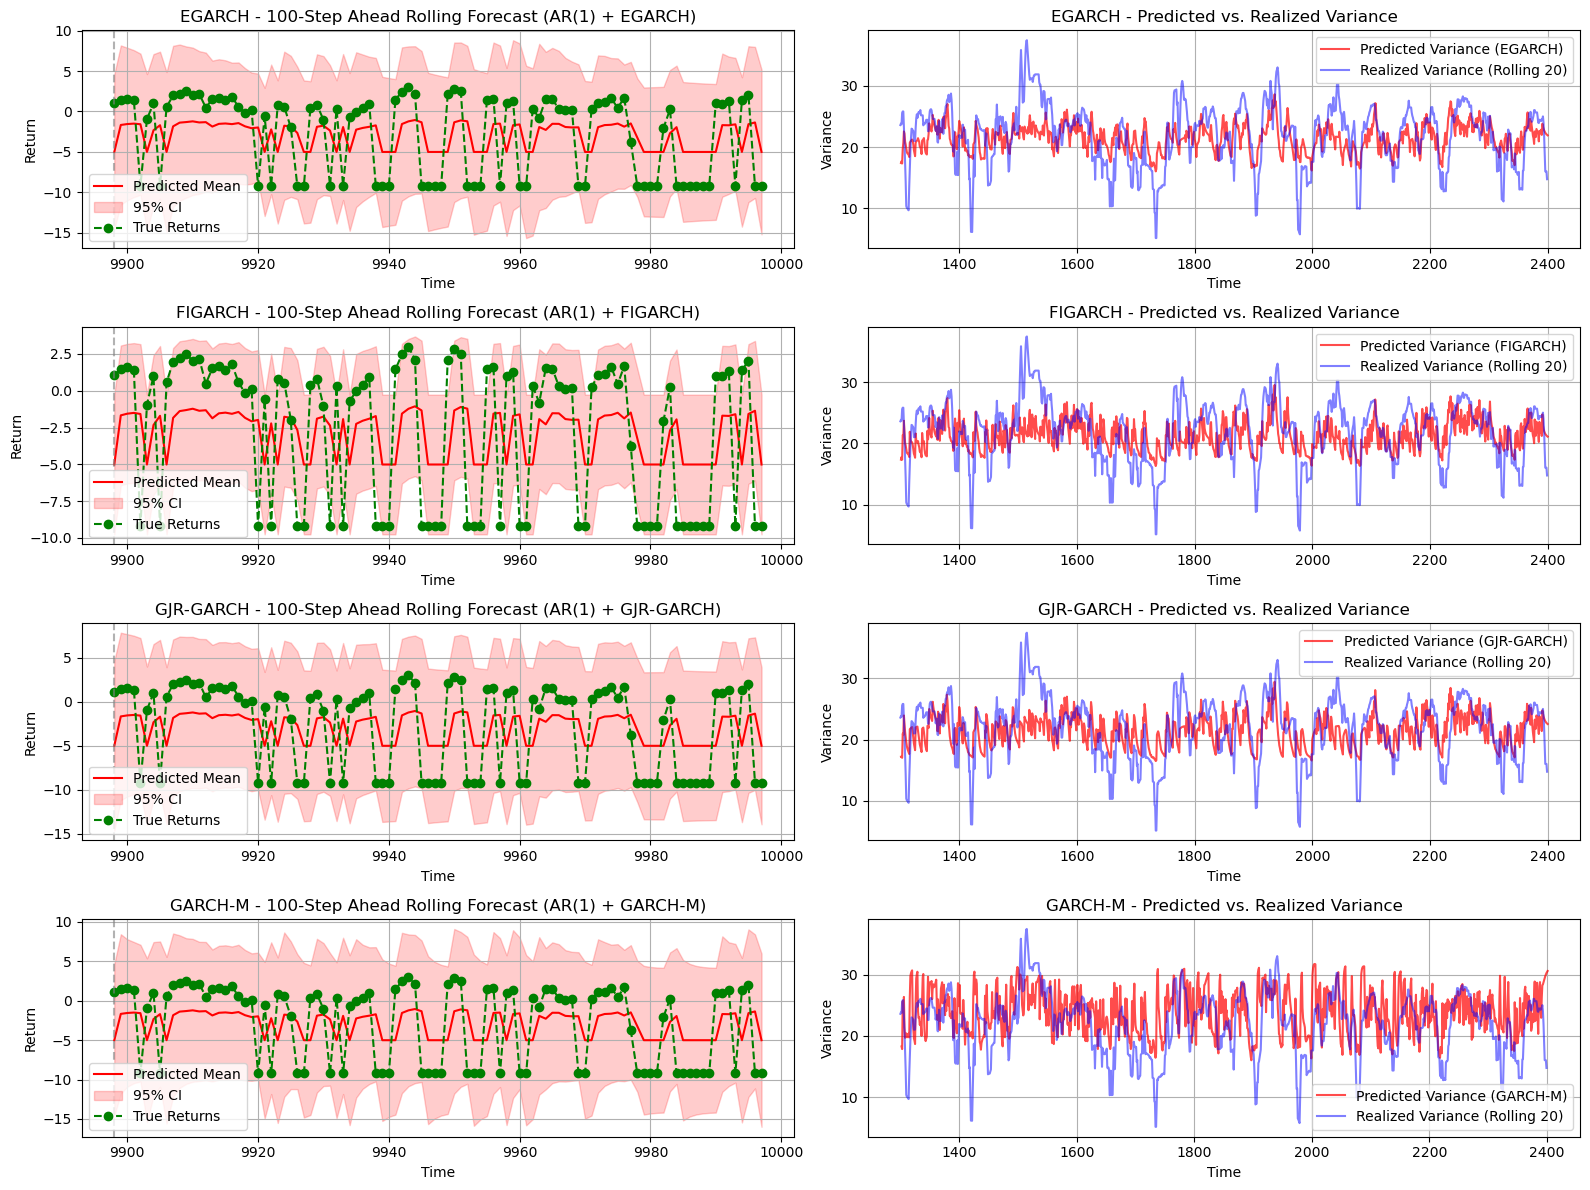

In [13]:
work(get_log_returns(synthetic_datasets[0]))

ARCH LM test p‑value = 0.0000
ARCH effect detected


c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005059. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


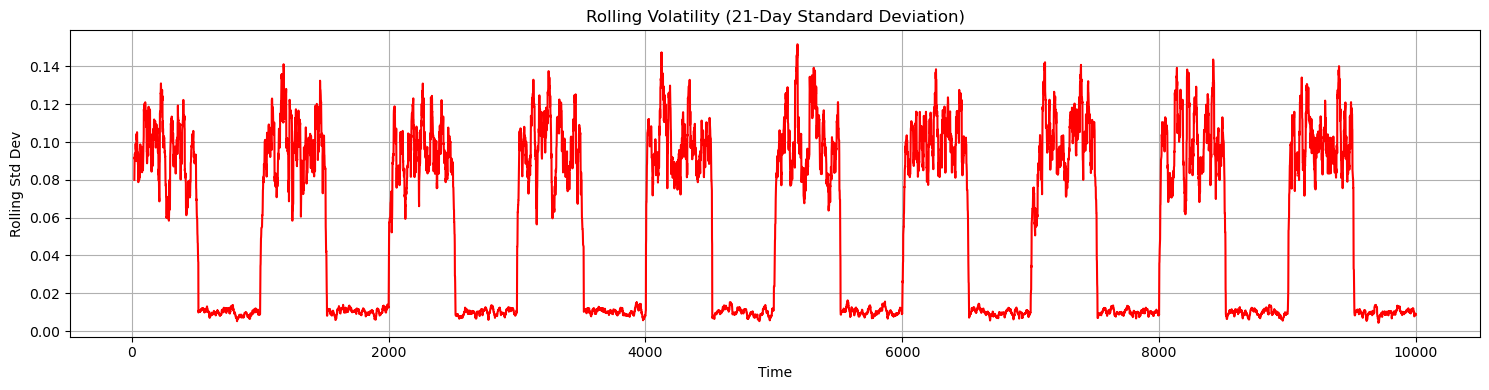

                            AutoReg Model Results                             
Dep. Variable:            Log_Returns   No. Observations:                10000
Model:                     AutoReg(1)   Log Likelihood               12242.368
Method:               Conditional MLE   S.D. of innovations              0.071
Date:                Sat, 12 Apr 2025   AIC                         -24478.736
Time:                        19:57:30   BIC                         -24457.105
Sample:                             1   HQIC                        -24471.414
                                10000                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0015      0.001     -2.096      0.036      -0.003   -9.71e-05
Log_Returns.L1    -0.0043      0.010     -0.427      0.669      -0.024       0.015
                                    

c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GARCH(2,1) - AIC: -15231.66, BIC: -15195.61
GARCH(2,2) - AIC: 14861.32, BIC: 14904.58
GARCH(2,3) - AIC: -17643.67, BIC: -17593.20
GARCH(2,4) - AIC: -12074.16, BIC: -12016.48
GARCH(3,1) - AIC: -17455.51, BIC: -17412.25
GARCH(3,2) - AIC: -10144.30, BIC: -10093.83
GARCH(3,3) - AIC: -11248.38, BIC: -11190.70
GARCH(3,4) - AIC: -33122.96, BIC: -33058.07
GARCH(4,1) - AIC: -15280.84, BIC: -15230.37


c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GARCH(4,2) - AIC: 33185.64, BIC: 33243.32
GARCH(4,3) - AIC: -11807.26, BIC: -11742.37
GARCH(4,4) - AIC: -35089.15, BIC: -35017.05

 Best GARCH Order (by AIC): GARCH(4, 4)
Forecasting for time step t = 5066
Using fallback lag parameter name: Log_Returns.L1
Using fallback AR lag parameter: Log_Returns.L1


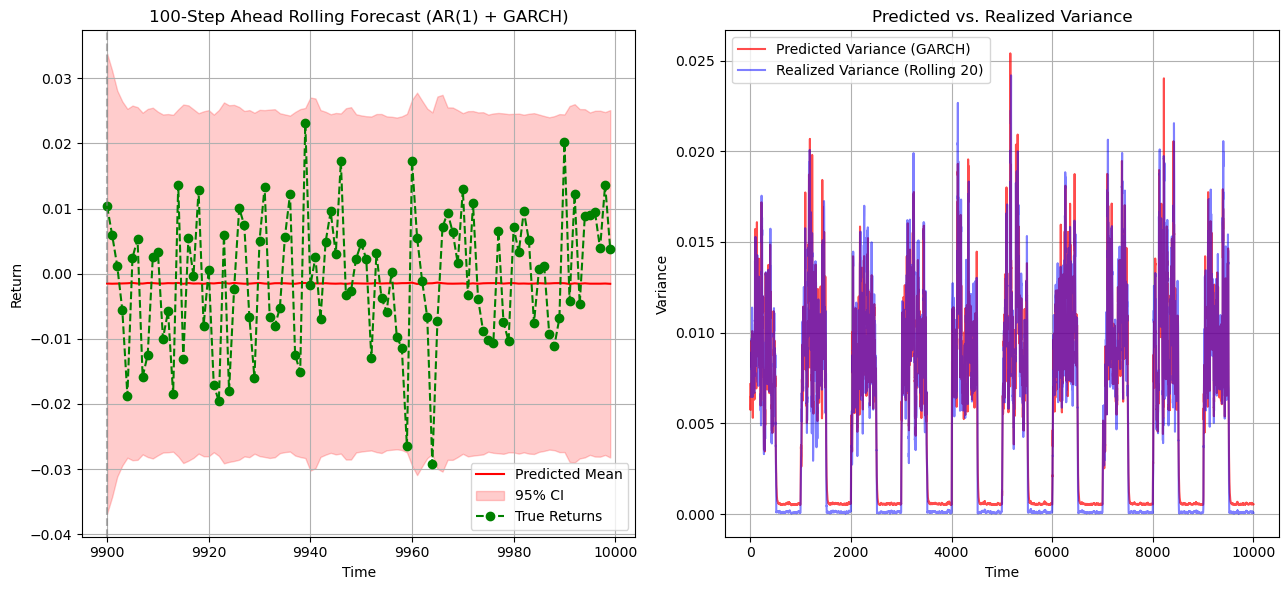

Total number of return observations: 10000
Testing range: start_t = 8000, end_t = 9998
z-value: 1.959963984540054
Using fallback AR lag parameter: Log_Returns.L1
Processing t = 8000 / 9998
Processing t = 8500 / 9998
Processing t = 9000 / 9998
Processing t = 9500 / 9998
User-defined Confidence Level: 95.0%
Observed Coverage: 67.57% (1350 out of 1998 instances)
RMSE between predicted and actual volatility: 0.0116

--- EGARCH (normal) Model Summary ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                19308.0
Distribution:                  Normal   AIC:                          -38607.9
Method:            Maximum Likelihood   BIC:                          -38579.1
                                        No. Observations:               

C:\Users\saket\AppData\Local\Temp\ipykernel_45284\2260959512.py:358: RuntimeWarning: invalid value encountered in sqrt
  pred_stds.append(np.sqrt(sigma2_pred))


GJR-GARCH - Confidence Interval Summary for the 100-step forecast:
Lower Bound: min = -0.0458, max = -0.0371
Upper Bound: min = 0.0341, max = 0.0430


================= Variant: GARCH-M =================
GARCH-M - Confidence Interval Summary for the 100-step forecast:
Lower Bound: min = -0.0531, max = -0.0449
Upper Bound: min = 0.0419, max = 0.0503



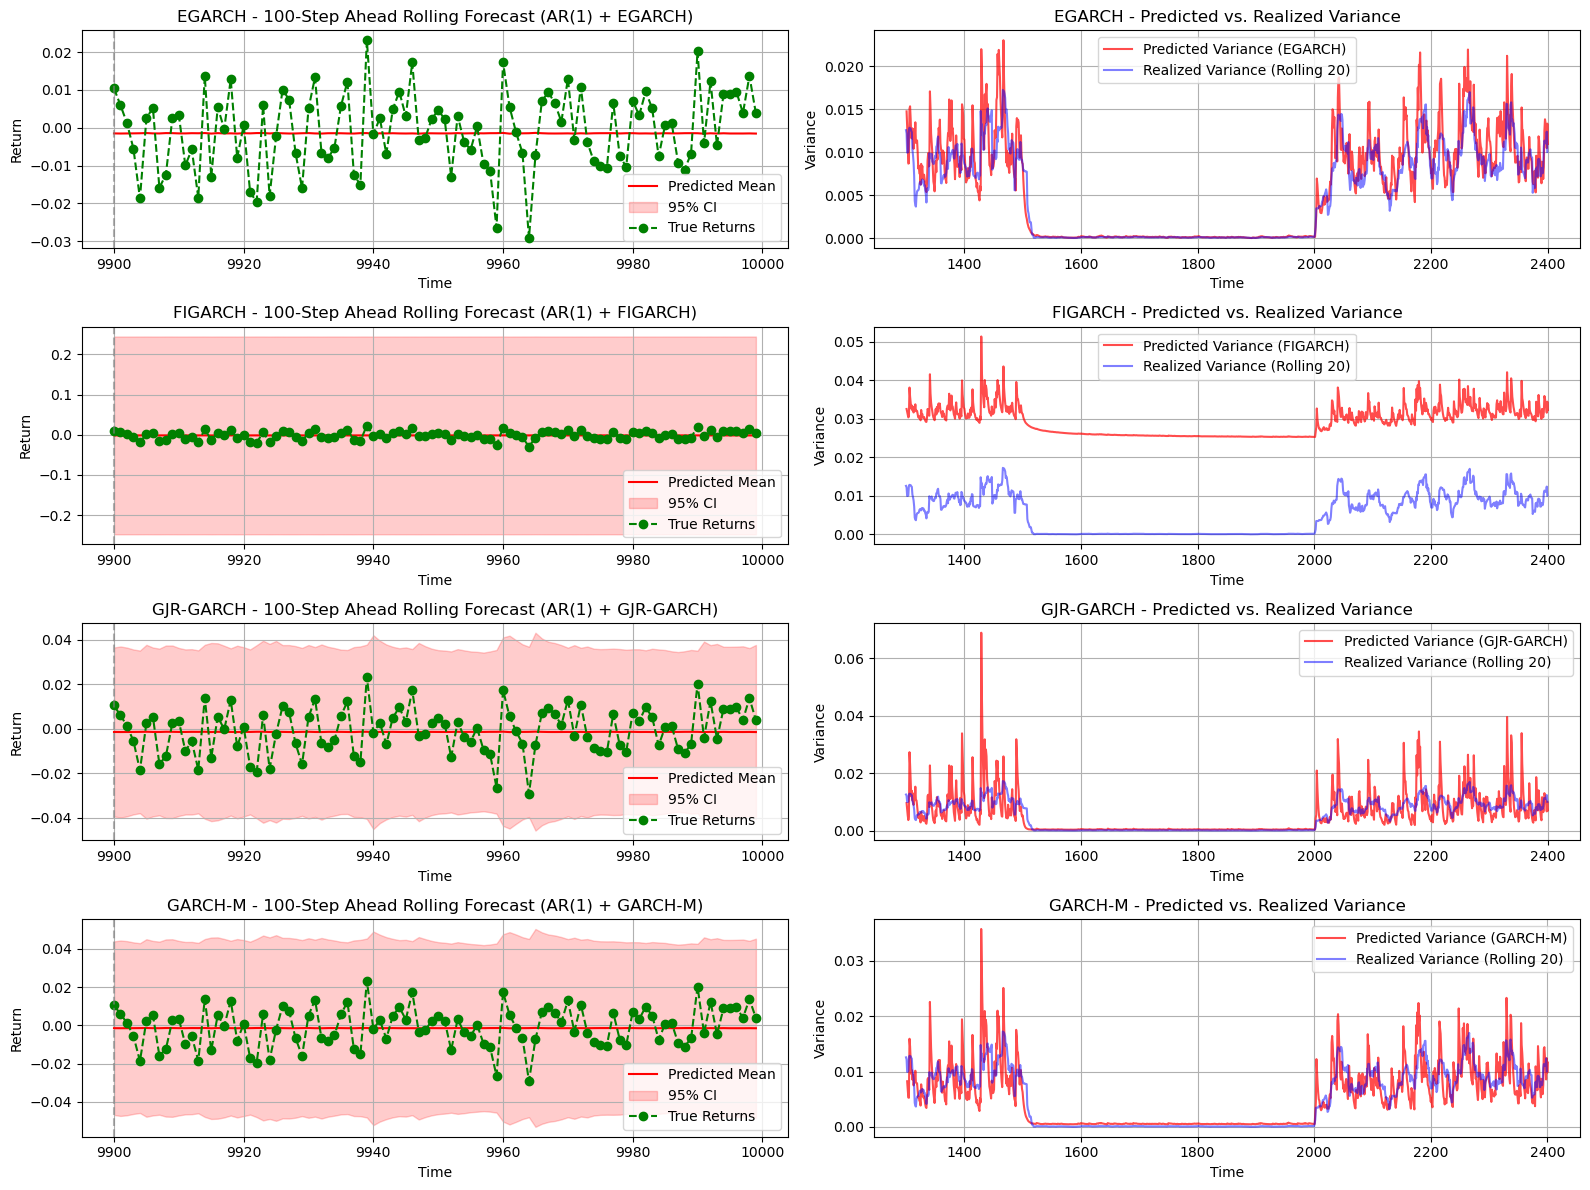

In [14]:
work(get_log_returns(synthetic_datasets[1]))

ARCH LM test p‑value = 1.0000
No ARCH effect detected


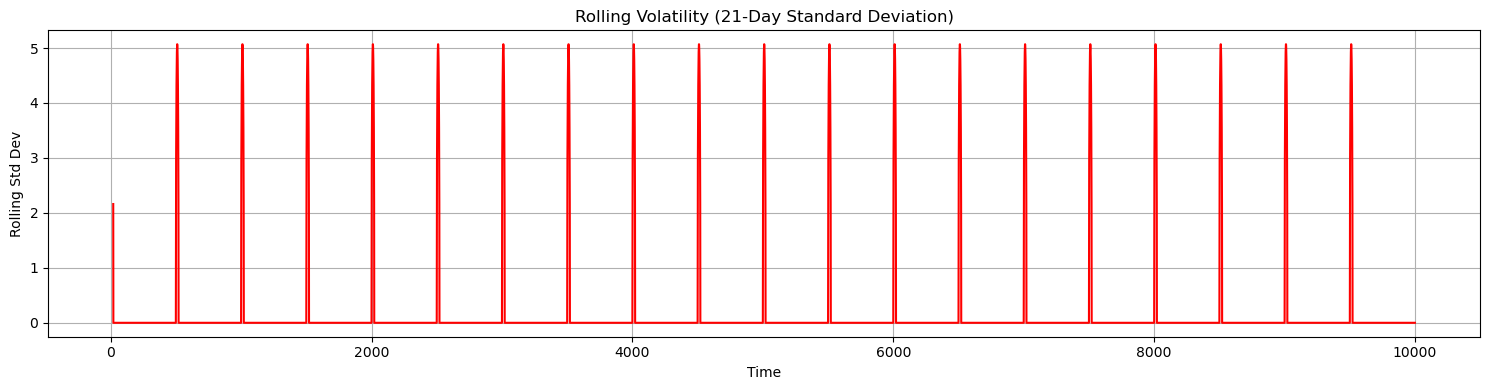

                            AutoReg Model Results                             
Dep. Variable:            Log_Returns   No. Observations:                10000
Model:                     AutoReg(1)   Log Likelihood               -6035.100
Method:               Conditional MLE   S.D. of innovations              0.442
Date:                Sat, 12 Apr 2025   AIC                          12076.200
Time:                        19:57:37   BIC                          12097.831
Sample:                             1   HQIC                         12083.522
                                10000                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0170      0.006     -2.919      0.004      -0.028      -0.006
Log_Returns.L1     0.9960      0.001   1114.565      0.000       0.994       0.998
                                    

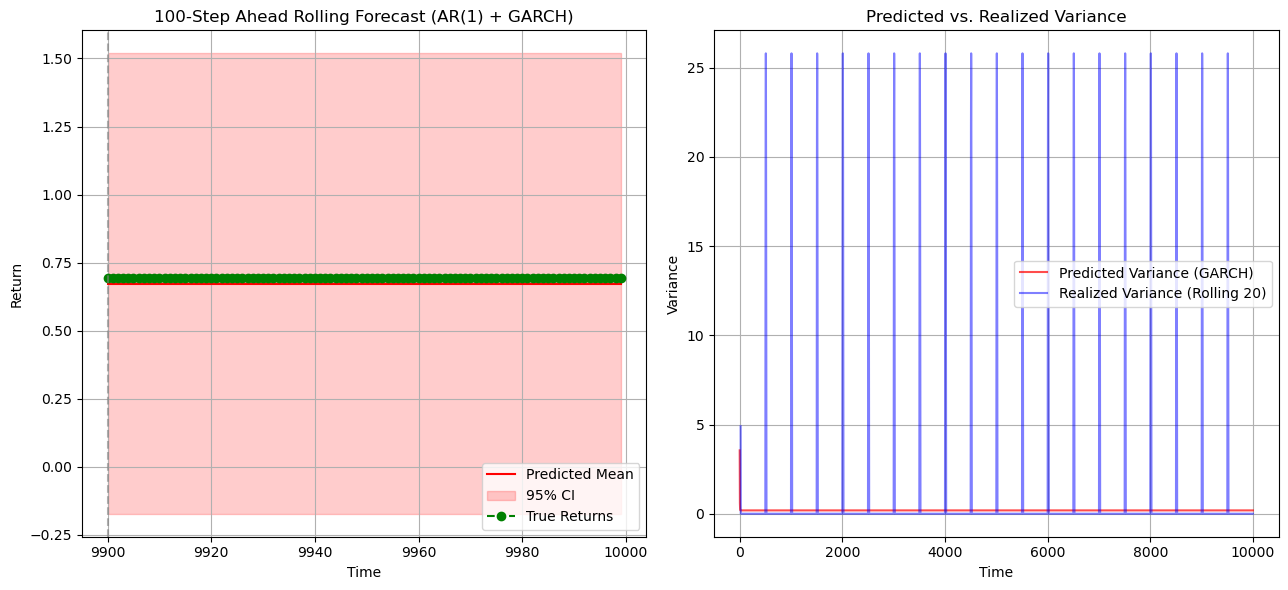

Total number of return observations: 10000
Testing range: start_t = 8000, end_t = 9998
z-value: 1.959963984540054
Using fallback AR lag parameter: Log_Returns.L1
Processing t = 8000 / 9998
Processing t = 8500 / 9998
Processing t = 9000 / 9998
Processing t = 9500 / 9998
User-defined Confidence Level: 95.0%
Observed Coverage: 99.60% (1990 out of 1998 instances)
RMSE between predicted and actual volatility: 0.8286

--- EGARCH (normal) Model Summary ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -5938.25
Distribution:                  Normal   AIC:                           11884.5
Method:            Maximum Likelihood   BIC:                           11913.3
                                        No. Observations:               

c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



--- FIGARCH (as FIGARCH mimic) Model Summary ---
                          AR - FIGARCH Model Results                          
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                    FIGARCH   Log-Likelihood:               -5851.04
Distribution:                  Normal   AIC:                           11712.1
Method:            Maximum Likelihood   BIC:                           11748.1
                                        No. Observations:                 9999
Date:                Sat, Apr 12 2025   Df Residuals:                     9998
Time:                        19:57:43   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const

c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



================= Variant: EGARCH =================
EGARCH - Confidence Interval Summary for the 100-step forecast:
Lower Bound: min = -4.7244, max = -4.7244
Upper Bound: min = 6.0710, max = 6.0710


================= Variant: FIGARCH =================
FIGARCH - Confidence Interval Summary for the 100-step forecast:
Lower Bound: min = -0.1719, max = -0.1719
Upper Bound: min = 1.5186, max = 1.5186


================= Variant: GJR-GARCH =================
GJR-GARCH - Confidence Interval Summary for the 100-step forecast:
Lower Bound: min = -0.1722, max = -0.1722
Upper Bound: min = 1.5189, max = 1.5189


================= Variant: GARCH-M =================
GARCH-M - Confidence Interval Summary for the 100-step forecast:
Lower Bound: min = -0.1483, max = -0.1483
Upper Bound: min = 1.4950, max = 1.4950



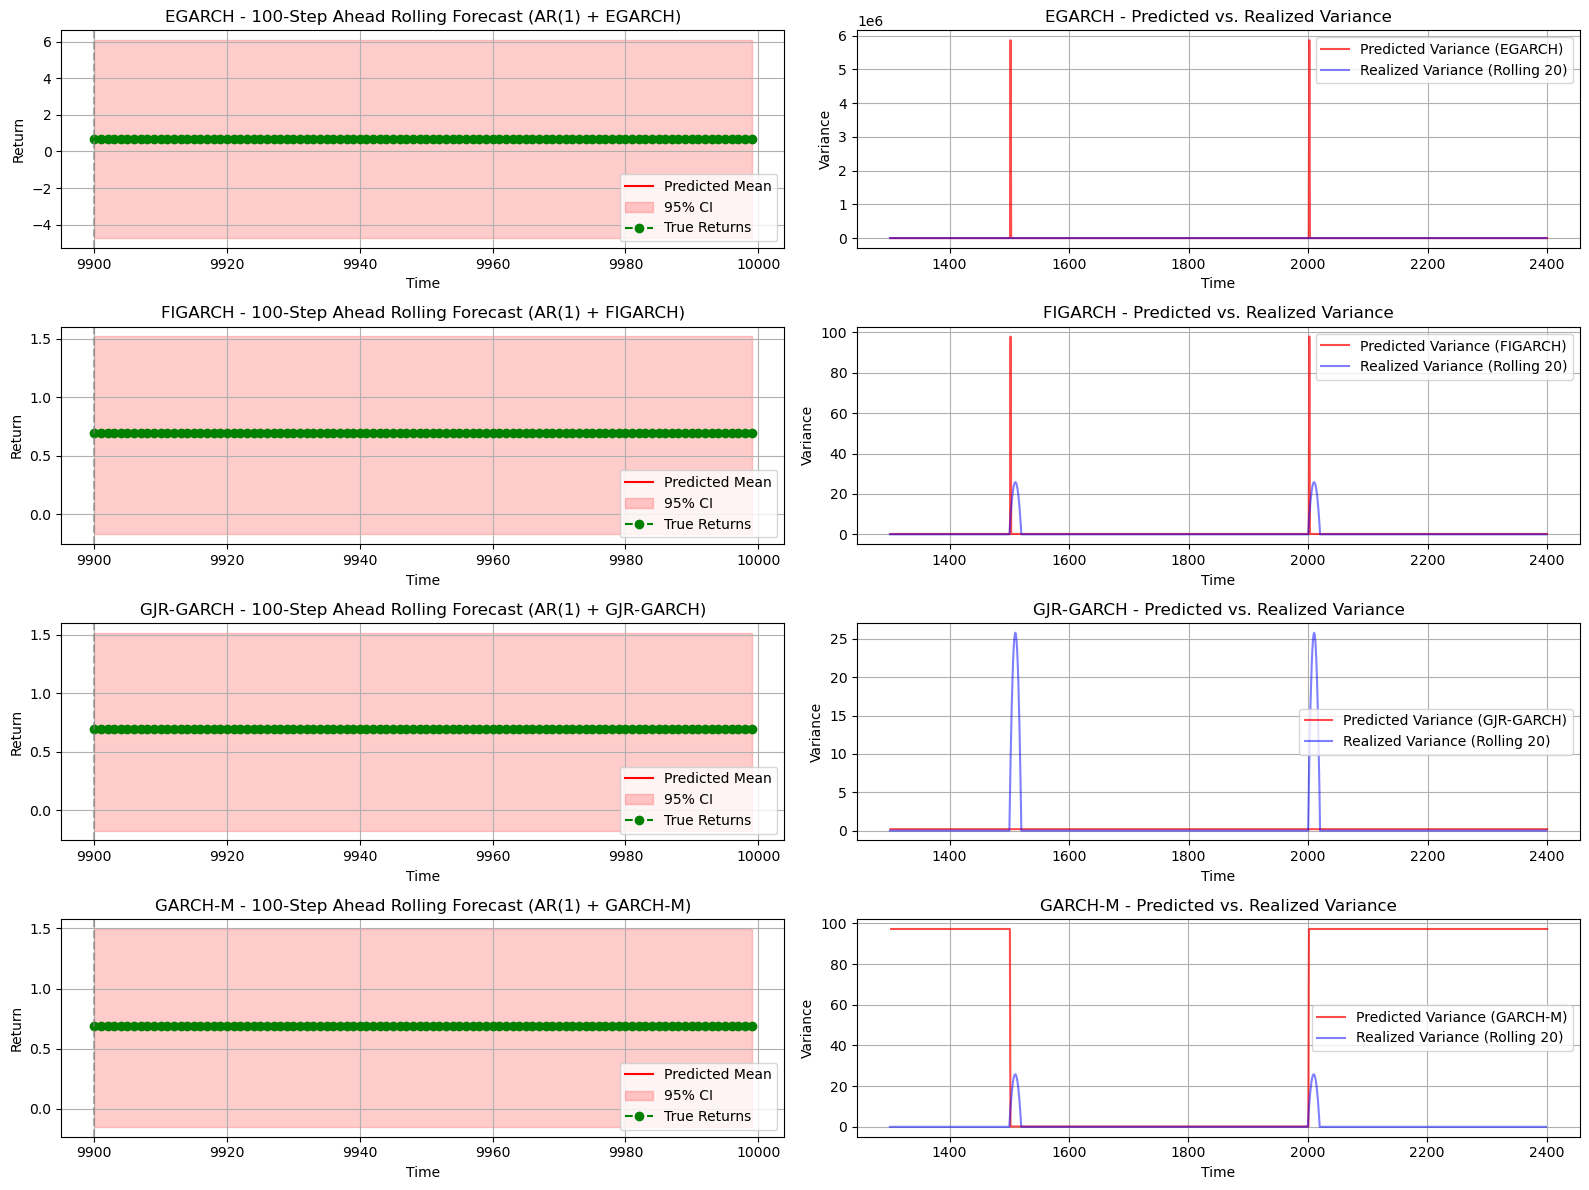

In [15]:
work(get_log_returns(synthetic_datasets[2]))

ARCH LM test p‑value = 0.9831
No ARCH effect detected


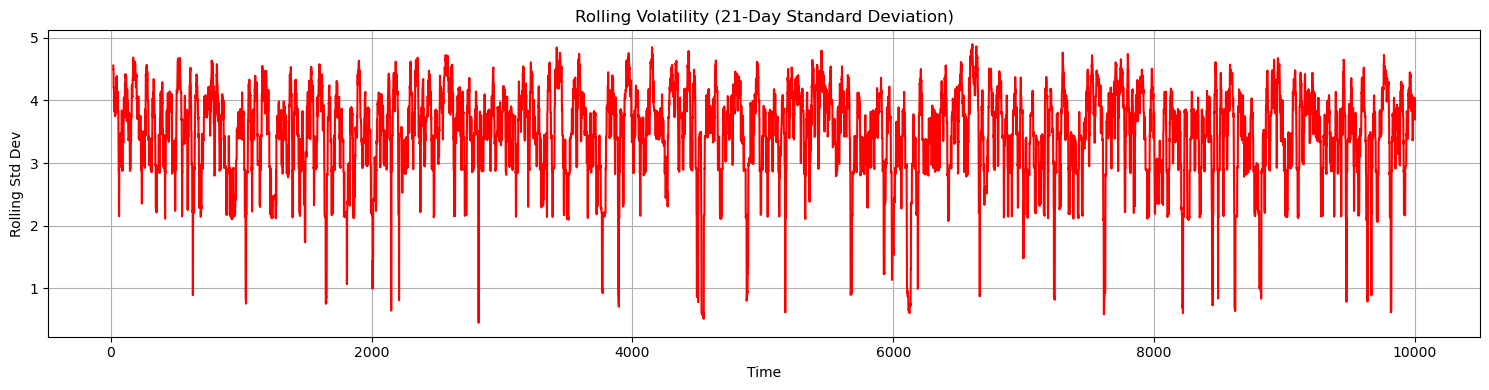

                            AutoReg Model Results                             
Dep. Variable:            Log_Returns   No. Observations:                10000
Model:                     AutoReg(1)   Log Likelihood              -26845.398
Method:               Conditional MLE   S.D. of innovations              3.546
Date:                Sat, 12 Apr 2025   AIC                          53696.795
Time:                        19:57:45   BIC                          53718.426
Sample:                             1   HQIC                         53704.117
                                10000                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.5419      0.039    -39.850      0.000      -1.618      -1.466
Log_Returns.L1     0.0040      0.010      0.397      0.692      -0.016       0.024
                                    

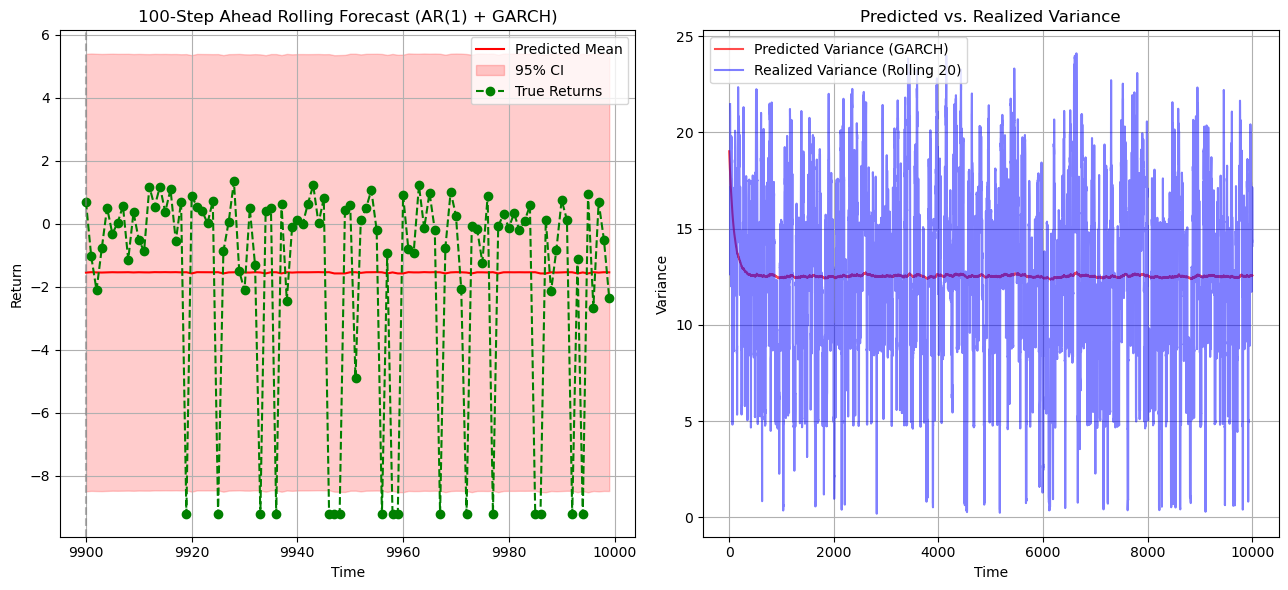

Total number of return observations: 10000
Testing range: start_t = 8000, end_t = 9998
z-value: 1.959963984540054
Using fallback AR lag parameter: Log_Returns.L1
Processing t = 8000 / 9998
Processing t = 8500 / 9998
Processing t = 9000 / 9998
Processing t = 9500 / 9998
User-defined Confidence Level: 95.0%
Observed Coverage: 84.53% (1689 out of 1998 instances)
RMSE between predicted and actual volatility: 0.7291

--- EGARCH (normal) Model Summary ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -26844.0
Distribution:                  Normal   AIC:                           53695.9
Method:            Maximum Likelihood   BIC:                           53724.8
                                        No. Observations:               

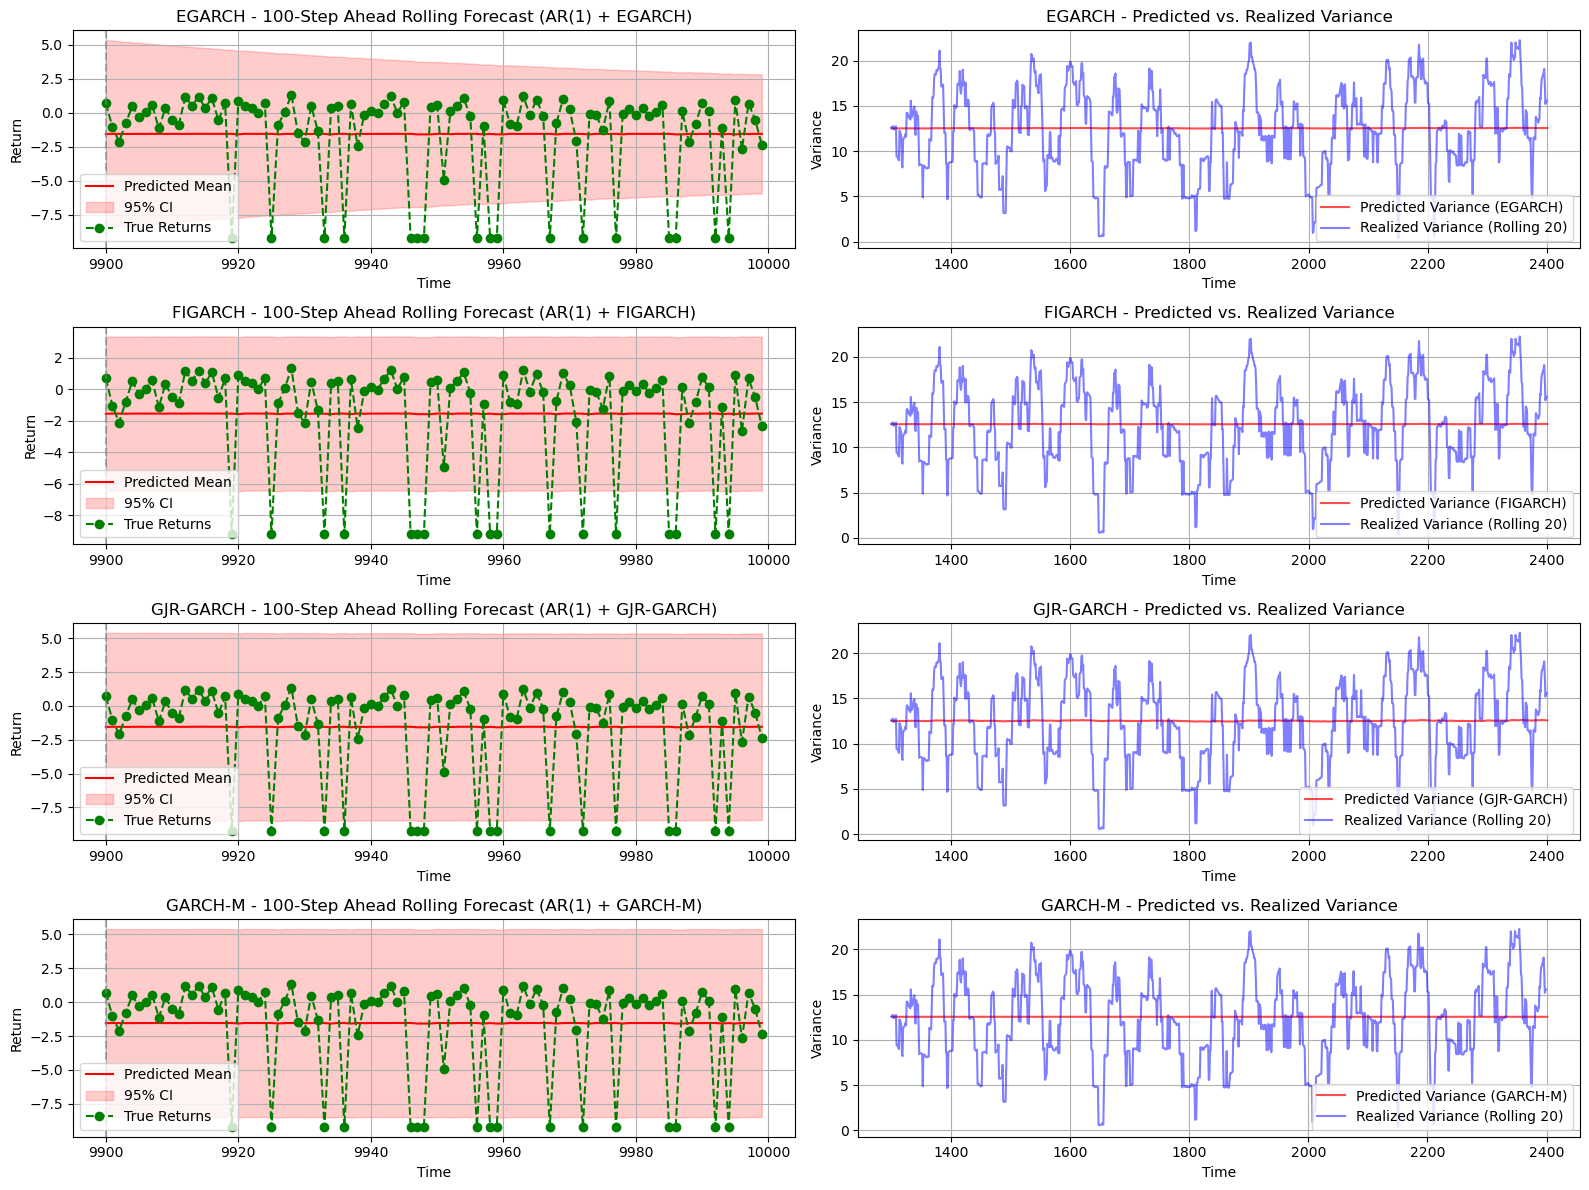

In [16]:
work(get_log_returns(synthetic_datasets[3]))

ARCH LM test p‑value = 0.0000
ARCH effect detected


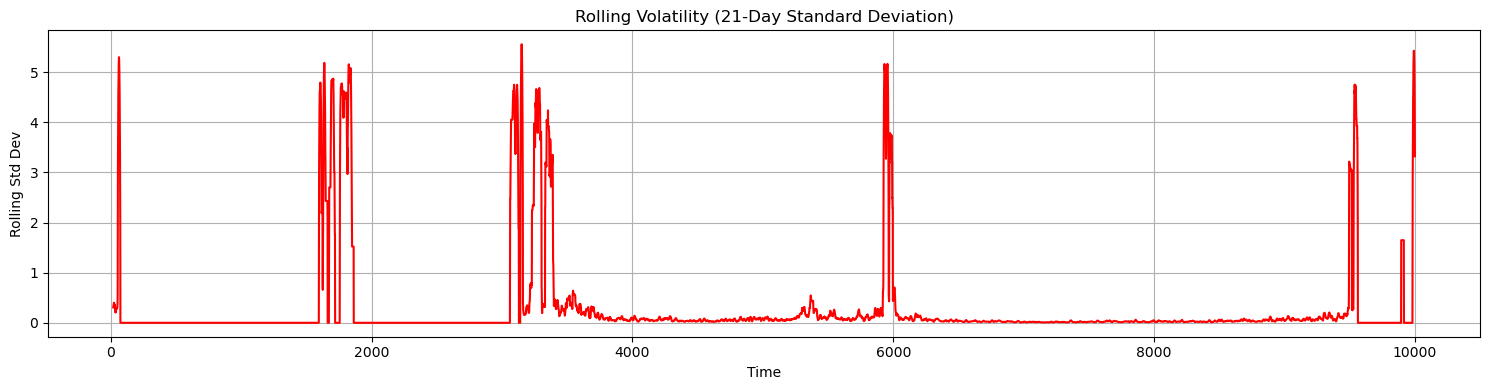

                            AutoReg Model Results                             
Dep. Variable:            Log_Returns   No. Observations:                10000
Model:                     AutoReg(1)   Log Likelihood              -12803.599
Method:               Conditional MLE   S.D. of innovations              0.871
Date:                Sat, 12 Apr 2025   AIC                          25613.198
Time:                        19:57:53   BIC                          25634.828
Sample:                             1   HQIC                         25620.519
                                10000                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0107      0.009     -1.208      0.227      -0.028       0.007
Log_Returns.L1     0.9895      0.001    685.632      0.000       0.987       0.992
                                    

c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GARCH(2,3) - AIC: 2079.14, BIC: 2129.61
GARCH(2,4) - AIC: 504.84, BIC: 562.53
GARCH(3,1) - AIC: 3581.38, BIC: 3624.64
GARCH(3,2) - AIC: 4190.17, BIC: 4240.64
GARCH(3,3) - AIC: 3509.03, BIC: 3566.71
GARCH(3,4) - AIC: 901.91, BIC: 966.80


c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GARCH(4,1) - AIC: 6978.14, BIC: 7028.61
GARCH(4,2) - AIC: 19615.15, BIC: 19672.84
GARCH(4,3) - AIC: 13016.41, BIC: 13081.30
GARCH(4,4) - AIC: 3192.56, BIC: 3264.66

 Best GARCH Order (by AIC): GARCH(2, 4)
Forecasting for time step t = 4194
Using fallback lag parameter name: Log_Returns.L1
Using fallback AR lag parameter: Log_Returns.L1


c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


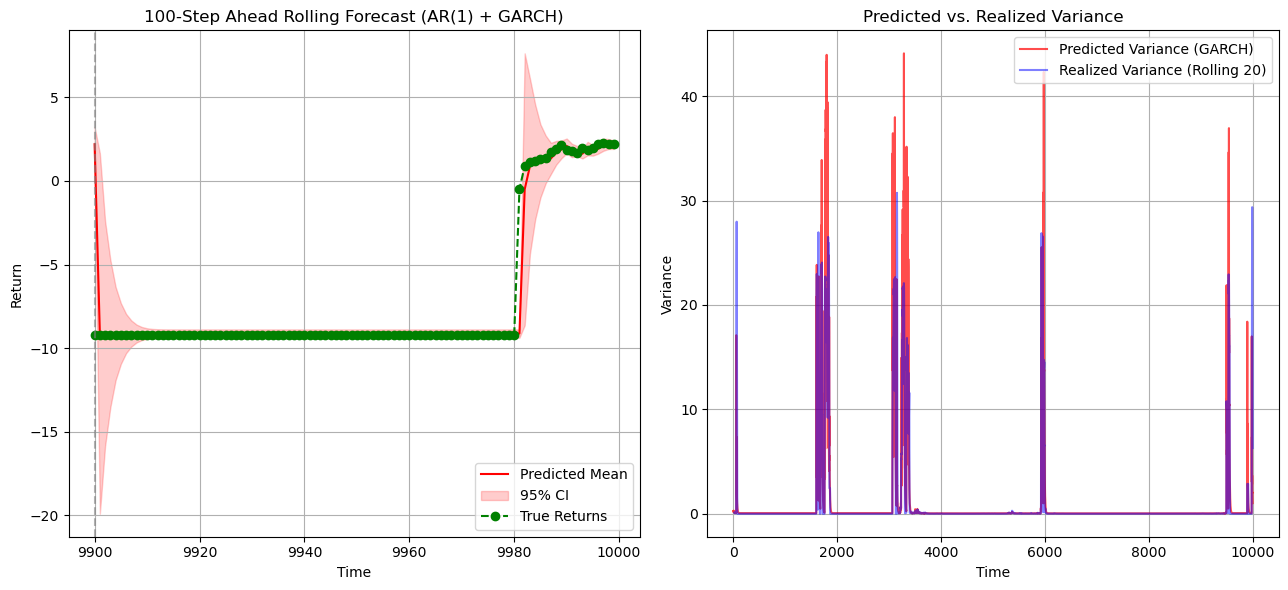

Total number of return observations: 10000
Testing range: start_t = 8000, end_t = 9998
z-value: 1.959963984540054
Using fallback AR lag parameter: Log_Returns.L1
Processing t = 8000 / 9998
Processing t = 8500 / 9998
Processing t = 9000 / 9998
Processing t = 9500 / 9998
User-defined Confidence Level: 95.0%
Observed Coverage: 99.15% (1981 out of 1998 instances)
RMSE between predicted and actual volatility: 0.7049

--- EGARCH (normal) Model Summary ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                7732.58
Distribution:                  Normal   AIC:                          -15457.2
Method:            Maximum Likelihood   BIC:                          -15428.3
                                        No. Observations:               

c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



--- FIGARCH (as FIGARCH mimic) Model Summary ---
                          AR - FIGARCH Model Results                          
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                    FIGARCH   Log-Likelihood:                4791.24
Distribution:                  Normal   AIC:                          -9572.47
Method:            Maximum Likelihood   BIC:                          -9536.42
                                        No. Observations:                 9999
Date:                Sat, Apr 12 2025   Df Residuals:                     9998
Time:                        19:58:00   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const   

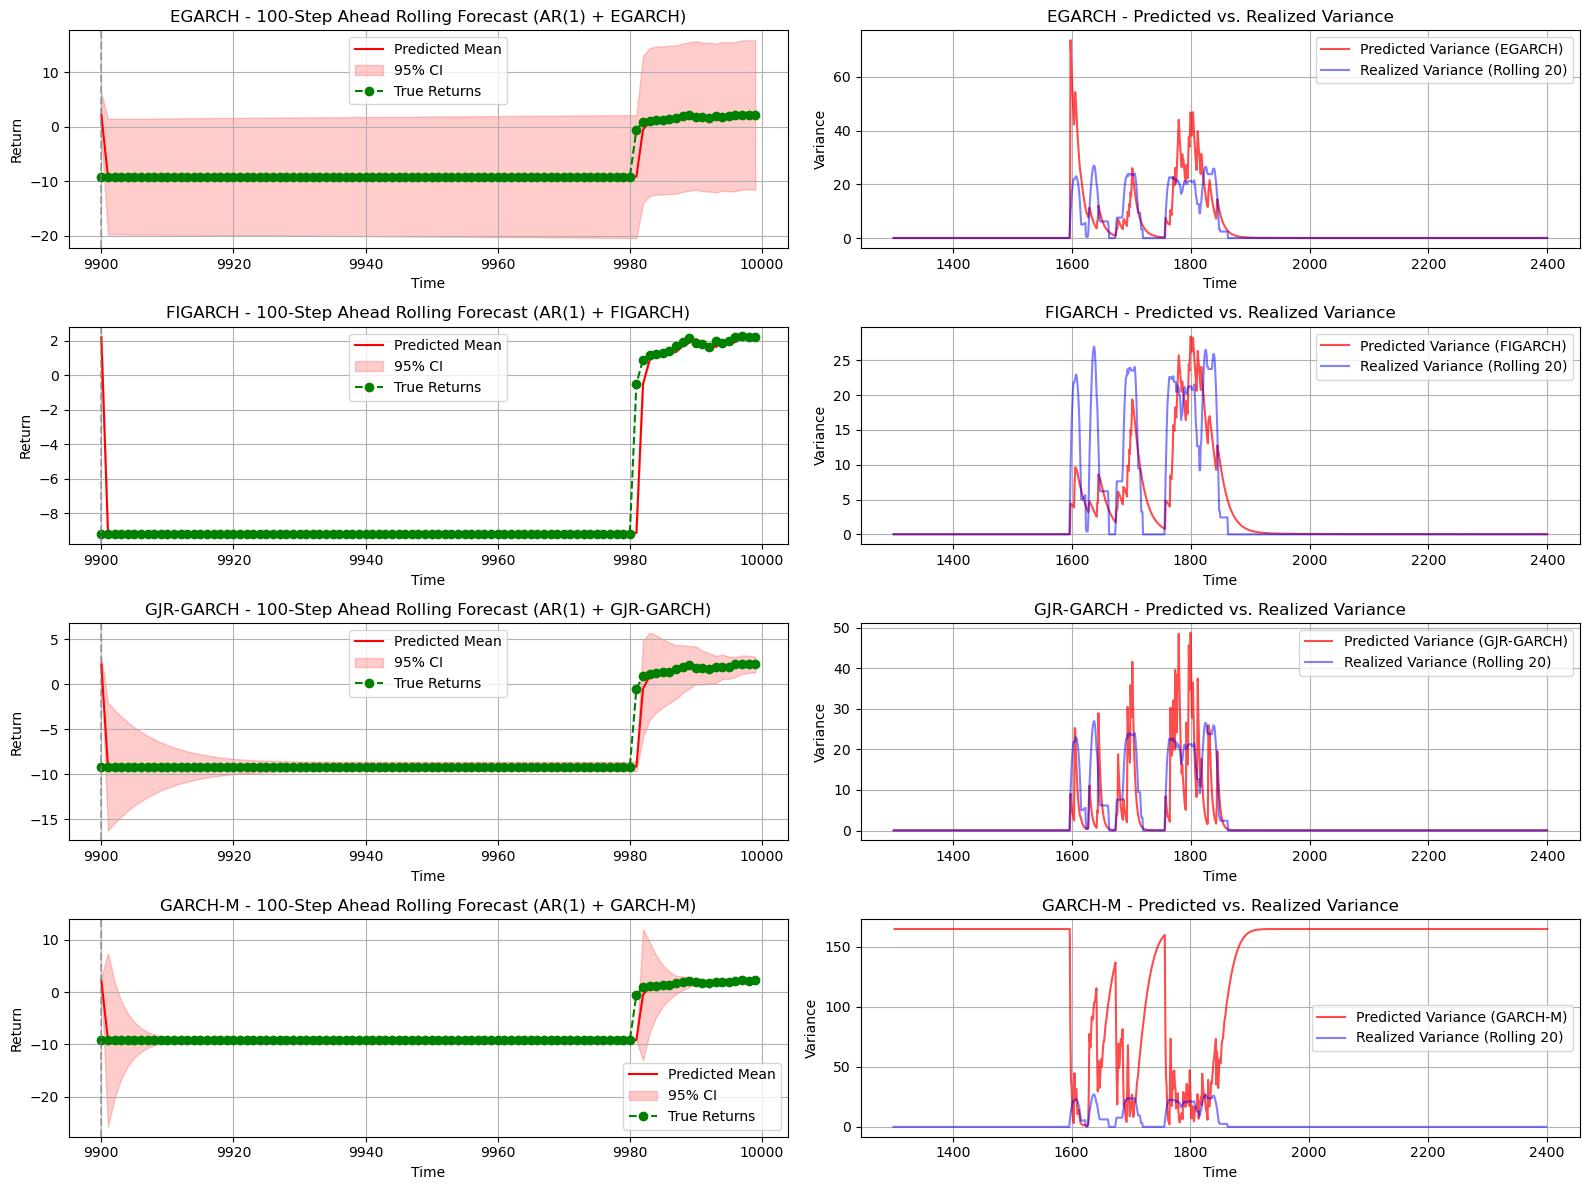

In [17]:
work(get_log_returns(synthetic_datasets[4]))

ARCH LM test p‑value = 0.3020
No ARCH effect detected


c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.542e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


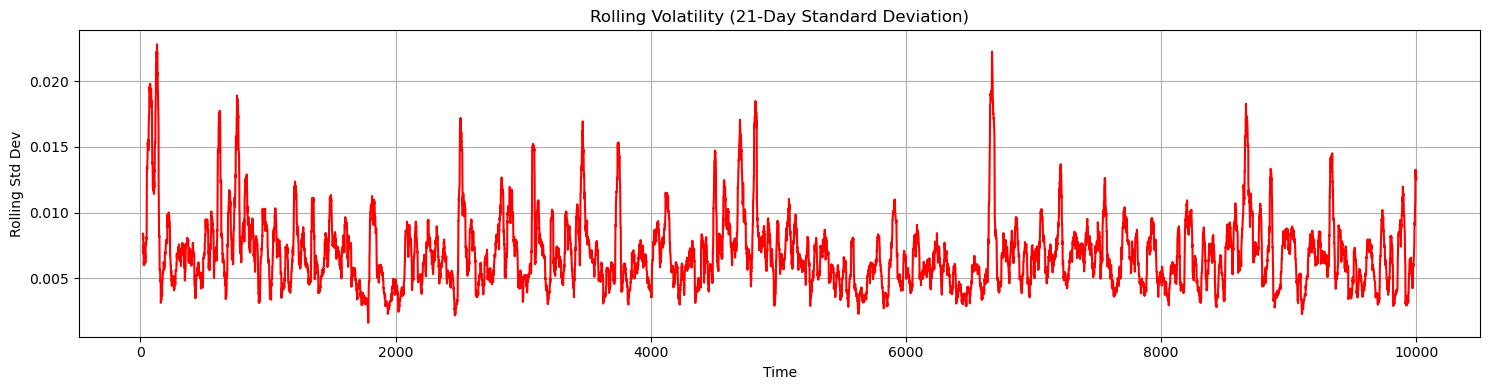

                            AutoReg Model Results                             
Dep. Variable:            Log_Returns   No. Observations:                10000
Model:                     AutoReg(1)   Log Likelihood               34810.079
Method:               Conditional MLE   S.D. of innovations              0.007
Date:                Sat, 12 Apr 2025   AIC                         -69614.158
Time:                        19:58:02   BIC                         -69592.528
Sample:                             1   HQIC                        -69606.837
                                10000                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.332e-05   7.44e-05      0.582      0.561      -0.000       0.000
Log_Returns.L1     0.0088      0.010      0.876      0.381      -0.011       0.028
                                    

c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GARCH(2,1) - AIC: -71331.45, BIC: -71295.39
GARCH(2,2) - AIC: -39516.76, BIC: -39473.50
GARCH(2,3) - AIC: -71377.98, BIC: -71327.51
GARCH(2,4) - AIC: -330.44, BIC: -272.75
GARCH(3,1) - AIC: 80865.55, BIC: 80908.81


c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GARCH(3,2) - AIC: -58780.79, BIC: -58730.32
GARCH(3,3) - AIC: 46177.13, BIC: 46234.81
GARCH(3,4) - AIC: -71324.07, BIC: -71259.18
GARCH(4,1) - AIC: -7373.32, BIC: -7322.84
GARCH(4,2) - AIC: -3185.08, BIC: -3127.40
GARCH(4,3) - AIC: -5758.35, BIC: -5693.46
GARCH(4,4) - AIC: 41494.14, BIC: 41566.25

 Best GARCH Order (by AIC): GARCH(2, 3)
Forecasting for time step t = 5651
Using fallback lag parameter name: Log_Returns.L1
Using fallback AR lag parameter: Log_Returns.L1


c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


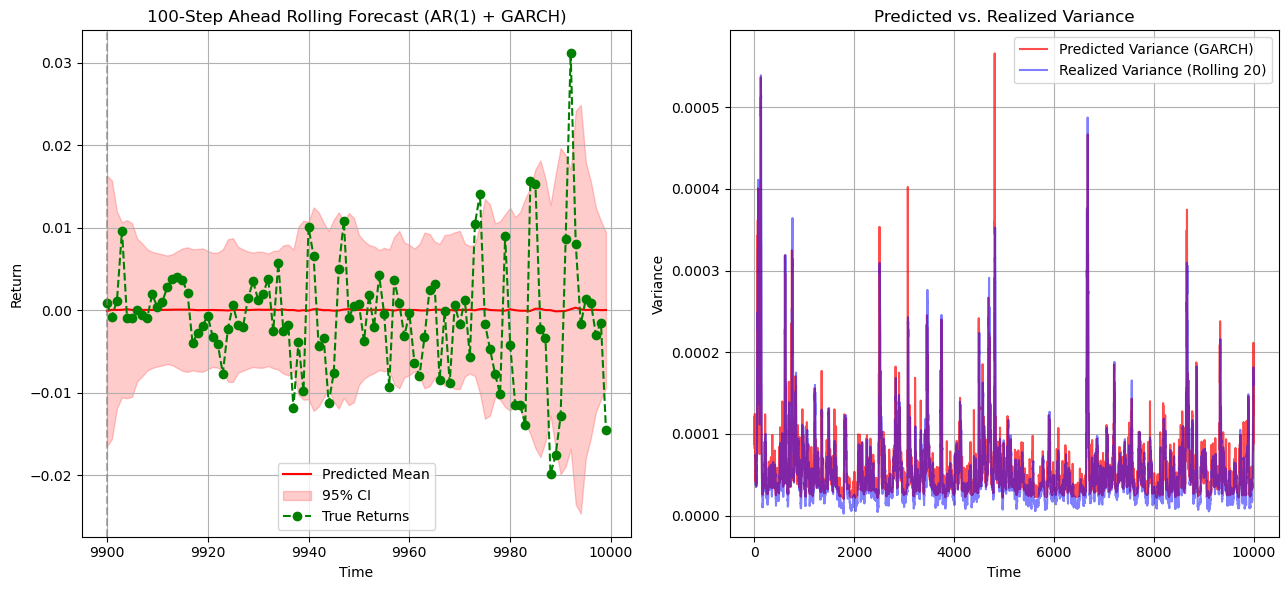

Total number of return observations: 10000
Testing range: start_t = 8000, end_t = 9998
z-value: 1.959963984540054
Using fallback AR lag parameter: Log_Returns.L1
Processing t = 8000 / 9998
Processing t = 8500 / 9998
Processing t = 9000 / 9998
Processing t = 9500 / 9998
User-defined Confidence Level: 95.0%
Observed Coverage: 98.30% (1964 out of 1998 instances)
RMSE between predicted and actual volatility: 0.0012

--- EGARCH (normal) Model Summary ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                35732.9
Distribution:                  Normal   AIC:                          -71457.9
Method:            Maximum Likelihood   BIC:                          -71429.0
                                        No. Observations:               

c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



--- FIGARCH (as FIGARCH mimic) Model Summary ---
                          AR - FIGARCH Model Results                          
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                    FIGARCH   Log-Likelihood:               -16544.0
Distribution:                  Normal   AIC:                           33098.0
Method:            Maximum Likelihood   BIC:                           33134.1
                                        No. Observations:                 9999
Date:                Sat, Apr 12 2025   Df Residuals:                     9998
Time:                        19:58:06   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         -0.855

c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\saket\AppData\Local\Temp\ipykernel_45284\2260959512.py:358: RuntimeWarning: invalid value encountered in sqrt
  pred_stds.append(np.sqrt(sigma2_pred))



================= Variant: GARCH-M =================
GARCH-M - Confidence Interval Summary for the 100-step forecast:
Lower Bound: min = -1.8028, max = -0.0174
Upper Bound: min = 0.0174, max = 1.8027



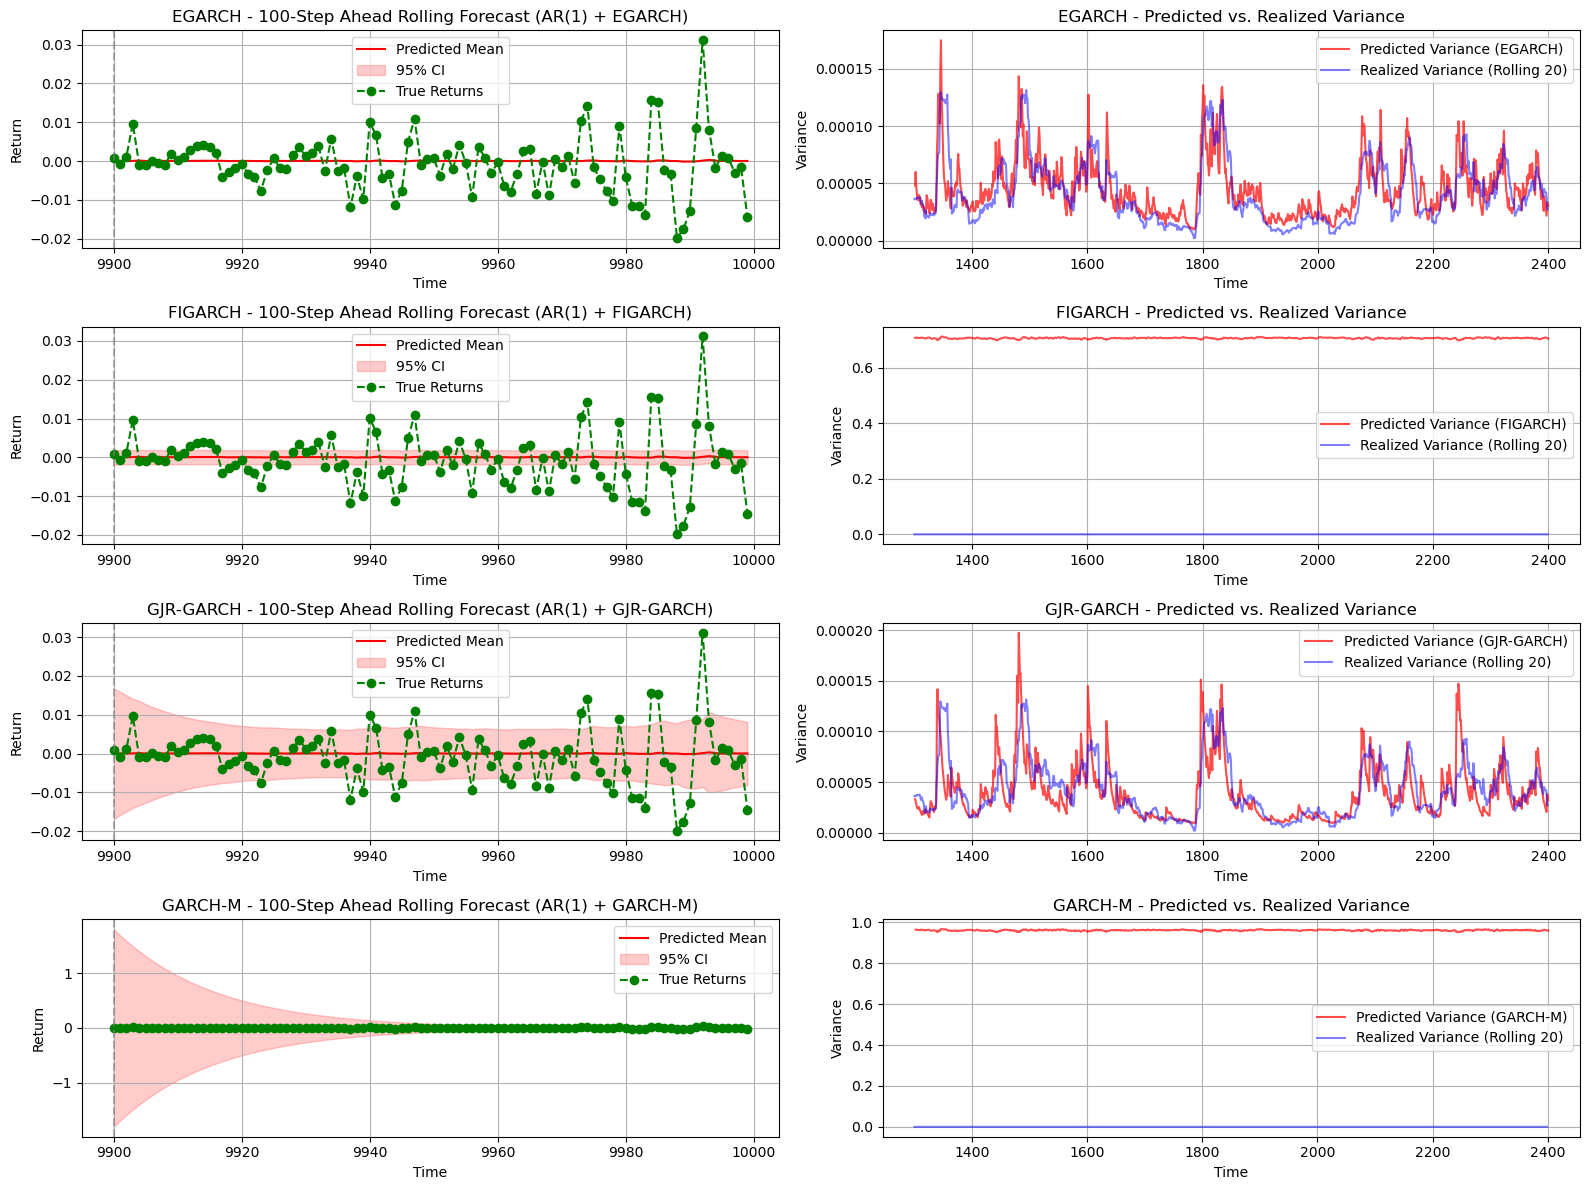

In [18]:
work(get_log_returns(synthetic_datasets[5]))

ARCH LM test p‑value = 0.4931
No ARCH effect detected


c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001007. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


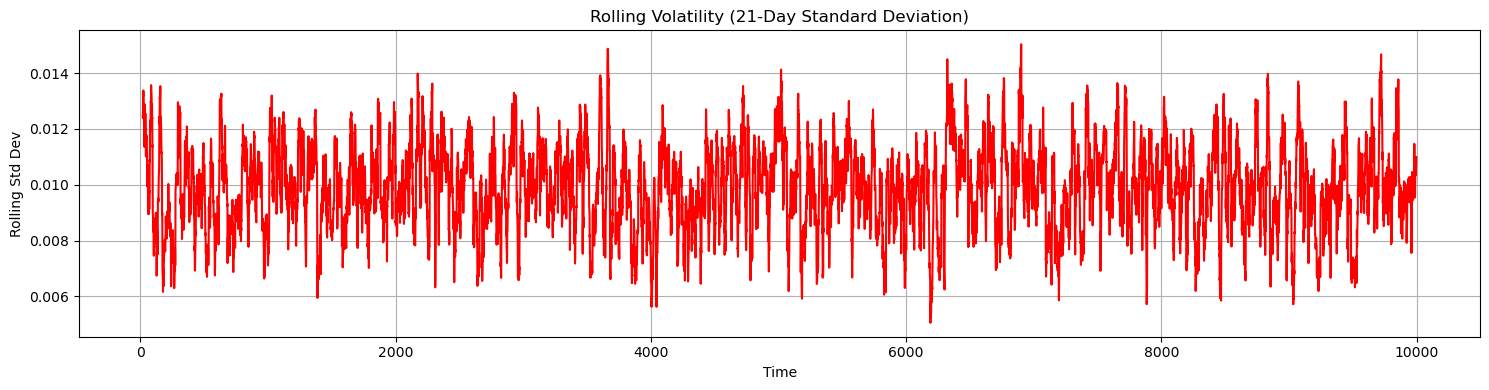

                            AutoReg Model Results                             
Dep. Variable:            Log_Returns   No. Observations:                 9999
Model:                     AutoReg(1)   Log Likelihood               31820.455
Method:               Conditional MLE   S.D. of innovations              0.010
Date:                Sat, 12 Apr 2025   AIC                         -63634.910
Time:                        19:58:08   BIC                         -63613.279
Sample:                             1   HQIC                        -63627.588
                                 9999                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0004      0.000      3.771      0.000       0.000       0.001
Log_Returns.L1     0.0099      0.010      0.994      0.320      -0.010       0.030
                                    

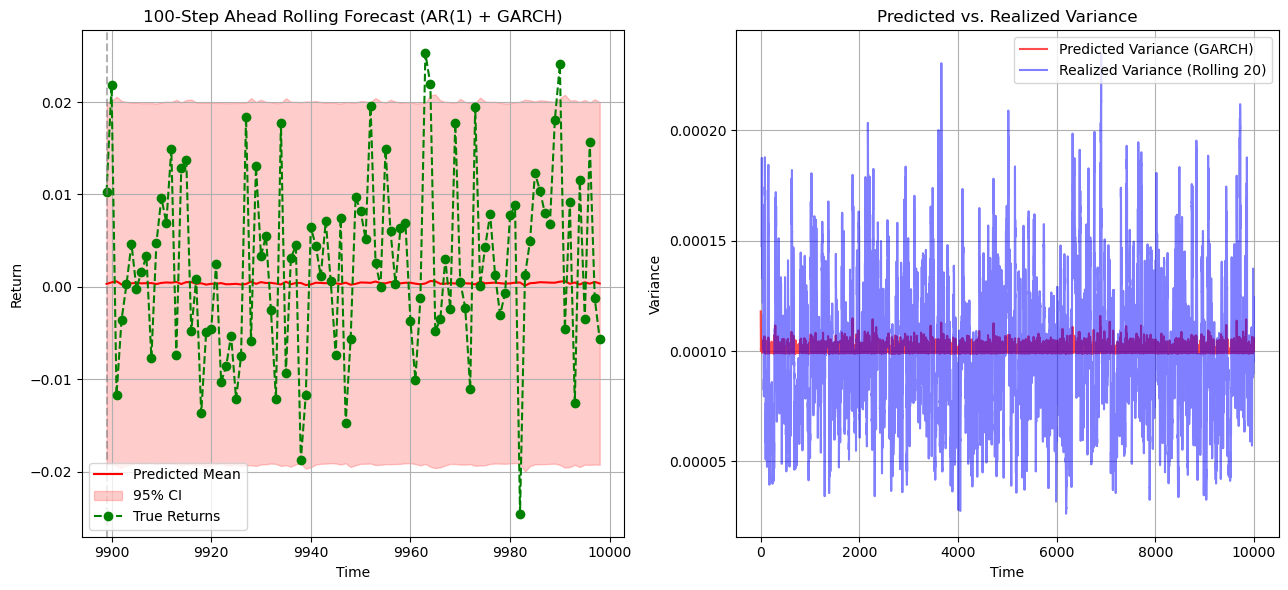

Total number of return observations: 9999
Testing range: start_t = 7999, end_t = 9997
z-value: 1.959963984540054
Using fallback AR lag parameter: Log_Returns.L1
Processing t = 8000 / 9997
Processing t = 8500 / 9997
Processing t = 9000 / 9997
Processing t = 9500 / 9997
User-defined Confidence Level: 95.0%
Observed Coverage: 94.84% (1895 out of 1998 instances)
RMSE between predicted and actual volatility: 0.0014

--- EGARCH (normal) Model Summary ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                31820.5
Distribution:                  Normal   AIC:                          -63633.0
Method:            Maximum Likelihood   BIC:                          -63604.1
                                        No. Observations:                

C:\Users\saket\AppData\Local\Temp\ipykernel_45284\2260959512.py:358: RuntimeWarning: invalid value encountered in sqrt
  pred_stds.append(np.sqrt(sigma2_pred))


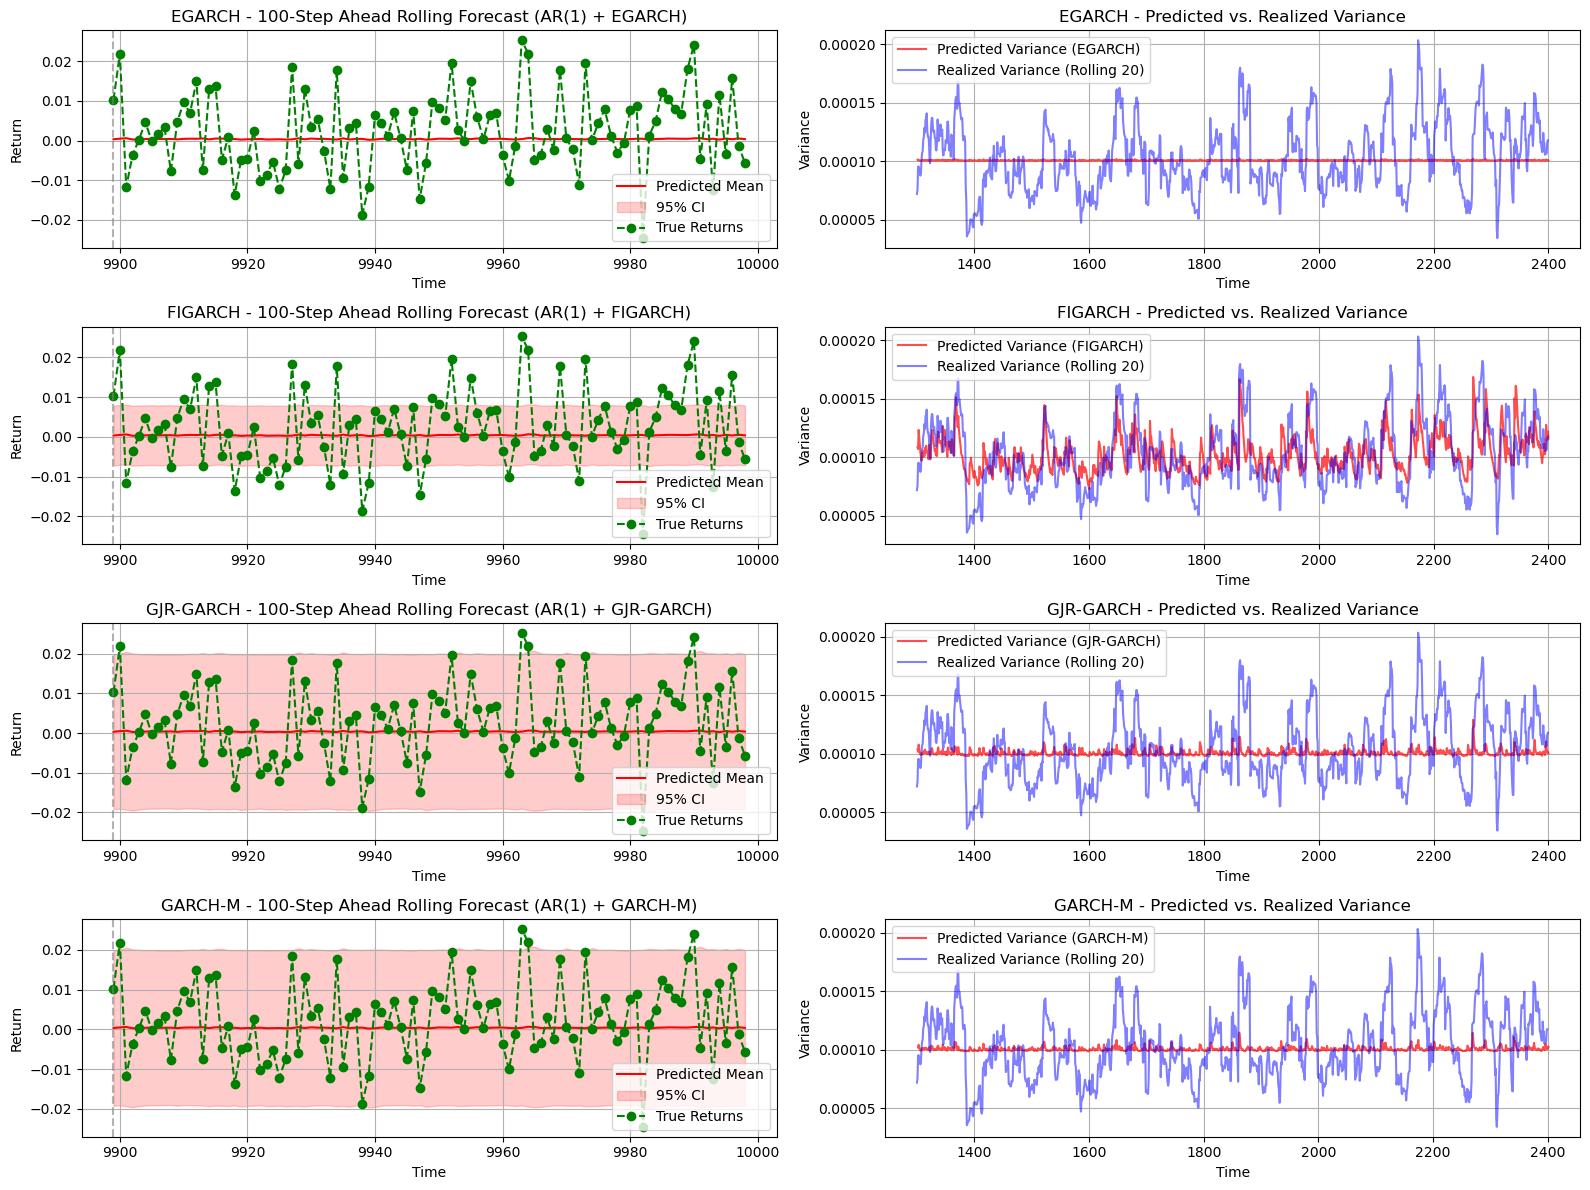

In [19]:
work(get_log_returns(synthetic_datasets[6]))